In [1]:
import os
from typing import List

import pandas as pd
import numpy as np
from IPython.display import display
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 

In [34]:
def readRecord(path, id):
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readFeature(path, id):
    recordFileName = os.path.join(path, 'features', f'feature-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def readFeatures(path, serverNum):
    recordList = [readFeature(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def dropWarmUpIdx(df, warmupDrop):
    # Drop warm up rows
    warmupDropTimestamp = df.loc[1, 'Start time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    keepIndices = df['Start time'] > warmupDropTimestamp
    return warmupDropTimestamp, keepIndices

def genSampleIdx(rowNum, sample):
    dropIndices = []
    if sample != None:
        removeN = rowNum - sample
        if removeN > 0:
            np.random.seed(55)
            dropIndices = np.random.choice(rowNum, removeN, replace=False)
    return dropIndices

def union(lst1, lst2):
    if len(lst1) == 0:
        final_list = lst2
    elif len(lst2) == 0:
        final_list = lst1
    else:
        final_list = lst1 + lst2
    return final_list

def dropOutliners(series, r):
    meanC = np.mean(series)
    stdC = np.std(series)

    # Drop rows that out of 'r' times of standard deviation
    indice = ((series < meanC + r * stdC) & (series > meanC - r * stdC))
    return indice

def histogram(series, targetName, unit):
    # Show histogram of the latency
    if unit == 'nano':
        # Nanosec
        series = series.to_numpy()
        nBins = np.unique(series)
        unit_str = 'nano sec'
    elif unit == 'micro':
        # Microsec
        series = np.round(series.to_numpy() / 1000, decimals=0)
        nBins = np.unique(series)
        unit_str = 'micro sec'
    else: 
        raise BaseException(f'No such unit: {unit}')

    # maxNBins = 1000
    # nBins = np.reshape(np.unique(series), (-1)).shape[0]
    # if nBins > maxNBins:
    #     nBins = maxNBins
    
    print(f'In {unit_str}, Number of bins: {nBins.shape[0]}, nBins: {nBins}')
    # Density
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, label='PMF')
    # plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

    # Cumulative
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}')
    plt.xlabel('Values (microsec)')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

def prepareData(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                featureNames: List[str], targetName: str,
                warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                histUnit: str="micro", dataUnit: str="micro", isSC: bool=False):

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_df_drop = feature_df.loc[keepIndices, :]
        target_df_drop = target_df.loc[keepIndices, :]
    else:
        feature_df_drop = feature_df
        target_df_drop = target_df

    # Drop outliners
    meanC = np.mean(target_df_drop[targetName])
    stdC = np.std(target_df_drop[targetName])
    print(f'Mean Latency: {meanC}, Std Latency: {stdC}')
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_df_drop[targetName], r=outlinerDrop)
        feature_df_drop = feature_df_drop.loc[outlinersIndice, :]
        target_df_drop = target_df_drop.loc[outlinersIndice, :]

    # Select features
    features = feature_df_drop[featureNames].reset_index(drop=True)
    # features = feature_df_drop.reset_index(drop=True)
    # features = feature_df_drop.drop(['Transaction ID', 'Start time'], axis=1).reset_index(drop=True)
    targets = target_df_drop[targetName].reset_index(drop=True)

    # Random draw samples
    dropIndices = genSampleIdx(rowNum=features.shape[0], sample=sample)
    features = features.drop(dropIndices).reset_index(drop=True)
    targets = targets.drop(dropIndices).reset_index(drop=True)

    # Draw histogram of the target latency
    histogram(targets, targetName=targetName, unit=histUnit)
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def plot(X_test, y_test, y_pred, name=''):
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(y_test, y_pred)

    plt.xlabel("True Latency")
    plt.ylabel("Predict Latency (in microsec)")
    plt.title(f'{name} Latency Prediction during benchmark')

    plt.axline((0, 0), (1, 1), color="black", linestyle=(0, (5, 5)))

    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

def fitModel(model, X_train, X_test, y_train, y_test, name=''):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy().ravel()
    y_test_np = y_test.to_numpy().ravel()

    model.fit(X_train_np, y_train_np)

    score = model.score(X_test_np, y_test_np)
    y_pred = model.predict(X_test_np)
    print(f"Score on test dataset: {score}")

    plot(X_test_np, y_test_np, y_pred, name=name)
    return model

def modelSearch(model, X_train, X_test, y_train, y_test, name, params, n_jobs=-1):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=n_jobs, verbose=2)
    bestModel = fitModel(gs, X_train, X_test, y_train, y_test, name=name)

    print(f'Best Params: {bestModel.best_params_}, with best scores: {bestModel.best_score_}')
    # res = pd.DataFrame(bestModel.cv_results_)
    # display(res)

In [35]:
# path = 'ous/Google-RTE_200-BS_200-RW_05'
path = 'ous/basic1_done'
serverNum = 1
warmupDrop = 90000000
# warmupDrop = 0
sampleN = 10000
# sampleN = None
outlinerDropR = 1

histUnit = 'micro'
isSaveFig=False

In [4]:
records = readRecords(path, serverNum)
print(f'Records: Time of Each Component with shape: {records.shape}')
display(records)

features = readFeatures(path, serverNum)
print(f'Features: Features with shape: {features.shape}')
display(features)

Records: Time of Each Component with shape: (150877, 17)


,Transaction ID,Execution Time,Txn Start TimeStamp,Generate plan,Init thread,Average Time Of Read-Only Txn,Get locks,(Master) Read from local storage,(Master) Read from remote,(Master) Execute SQL,(Master) Push,Flush,Tx commit,Release Lock,Unpin,Txn End TimeStamp,Average Time Of R/W Txn
0,1,20362986,2250503029529294,2847249,456453,13095469,90900,12792086,11255,56390,2832,74596,29495,14762,4239,2250503045391985,0
1,2,2143352,2250503136620783,77493,500633,1348284,14732,1270287,7840,5677,625,5692,26132,12502,4740,2250503138149540,0
2,3,2204376,2250503142024508,64066,495730,1554374,12133,1499479,1678,4854,649,5363,23281,11991,4059,2250503143637953,0
3,4,1882817,2250503147249416,186684,459323,1135439,13775,1069852,1648,4916,666,5131,32694,11245,3964,2250503148455221,0
4,5,2103482,2250503152094713,112799,404649,1501937,11531,1427560,1637,14023,633,8506,31362,20758,3442,2250503153651830,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150872,150873,201344,2250802957234315,53964,39933,90077,1563,83456,274,650,47,425,2532,997,340,2250802957341133,0
150873,150874,160382,2250802958835767,22922,29927,90876,2025,84239,285,512,47,395,2377,874,402,2250802958942581,0
150874,150875,178306,2250802960472124,28500,39568,93462,1556,87453,258,490,46,363,2325,915,350,2250802960591214,0
150875,150876,207385,2250802962130670,52318,46697,91051,1636,84460,272,578,49,404,2480,999,354,2250802962238388,0


Features: Features with shape: (150877, 15)


,Transaction ID,Start time,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes
0,1,0,2,0,1,50,0.0,4,0,0,0,0,0,2,0
1,2,110979929,2,0,1,50,0.0,4,0,0,0,0,0,2,0
2,3,116407350,2,0,1,50,1.0,4,0,0,0,0,0,2,0
3,4,121546326,2,0,1,50,0.0,4,0,0,0,0,0,2,0
4,5,126522216,2,0,1,50,2.0,4,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150872,150873,299932114293,2,0,1,50,0.0,4,0,0,0,0,0,2,0
150873,150874,299933756751,2,0,1,50,0.0,4,0,0,0,0,0,2,0
150874,150875,299935377874,2,0,1,50,6.0,4,0,0,0,0,0,2,0
150875,150876,299937005551,2,0,1,50,0.0,4,0,0,0,0,0,2,0


# Transction Commit

Warm Up Drop Timestamp: 200979929
Mean Latency: 2470.6559744925694, Std Latency: 2317.4061442379525
In micro sec, Number of bins: 5, nBins: [1. 2. 3. 4. 5.]


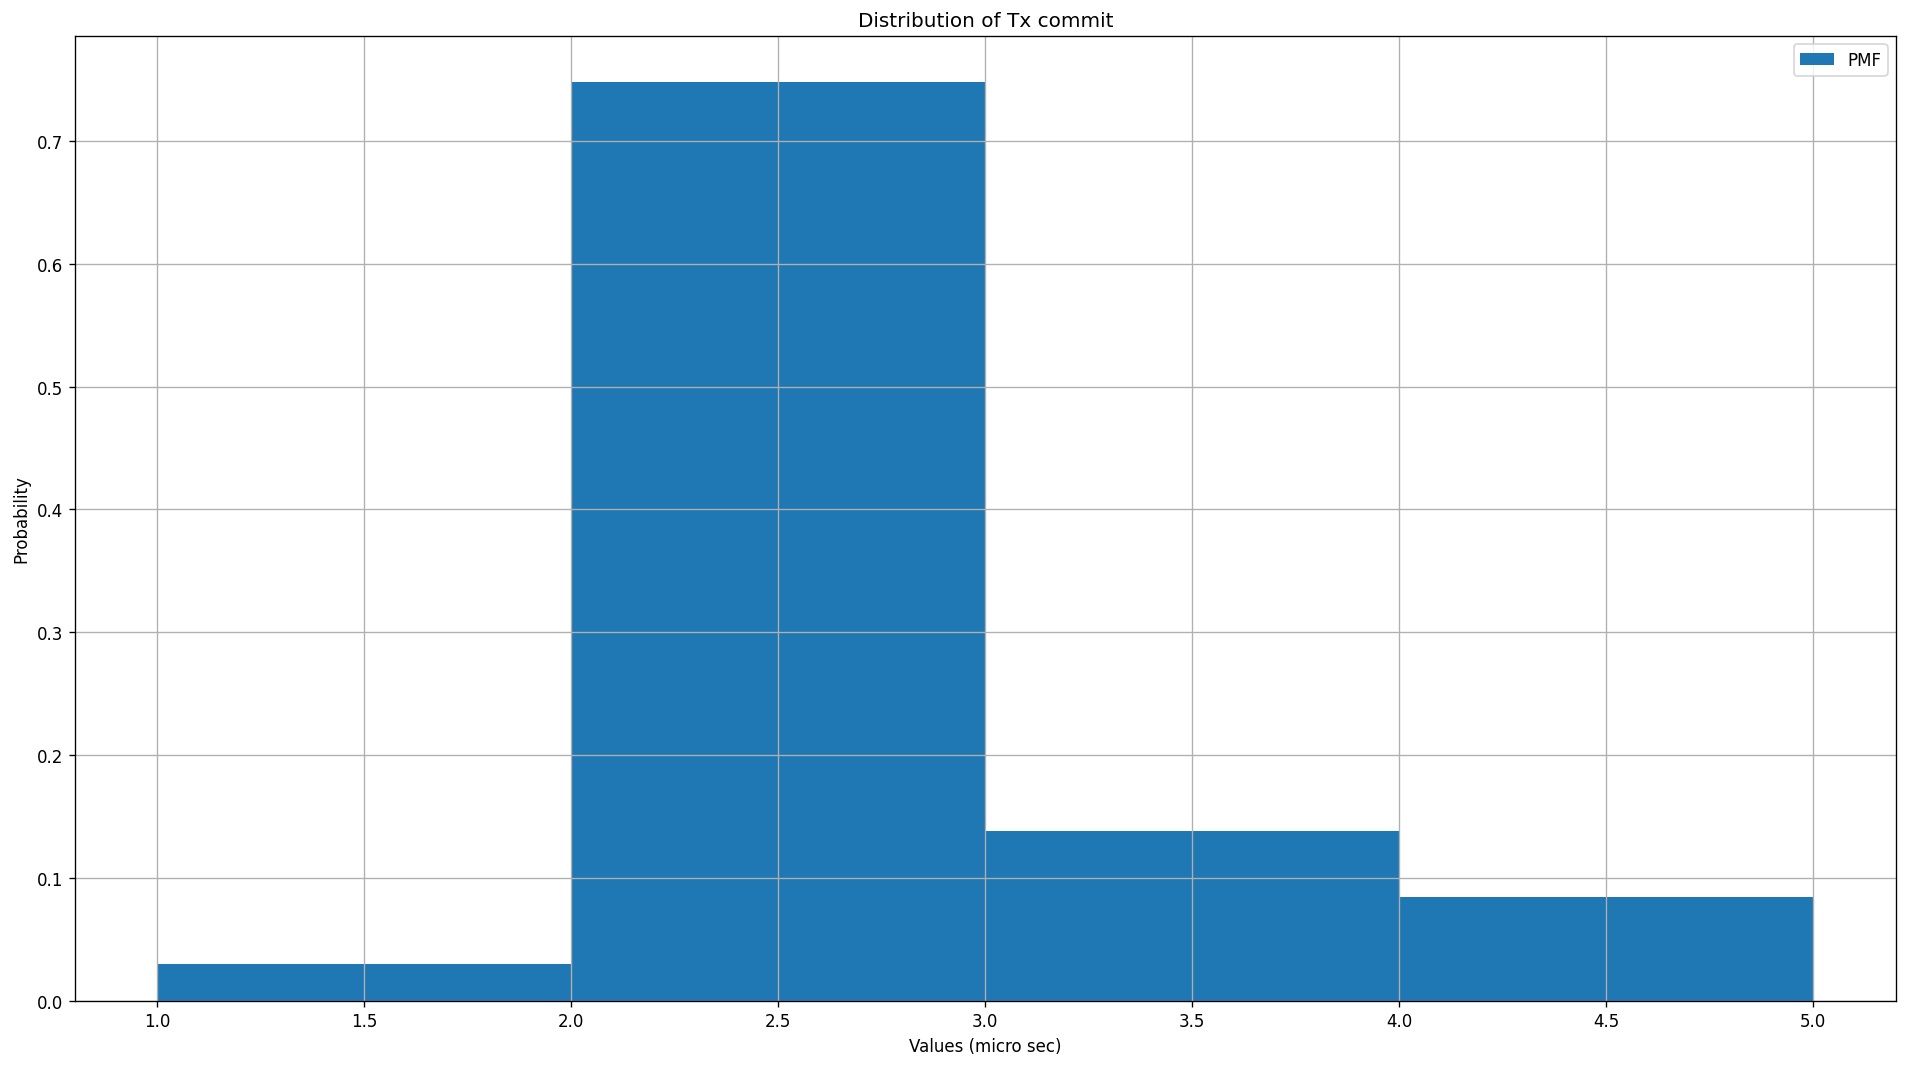

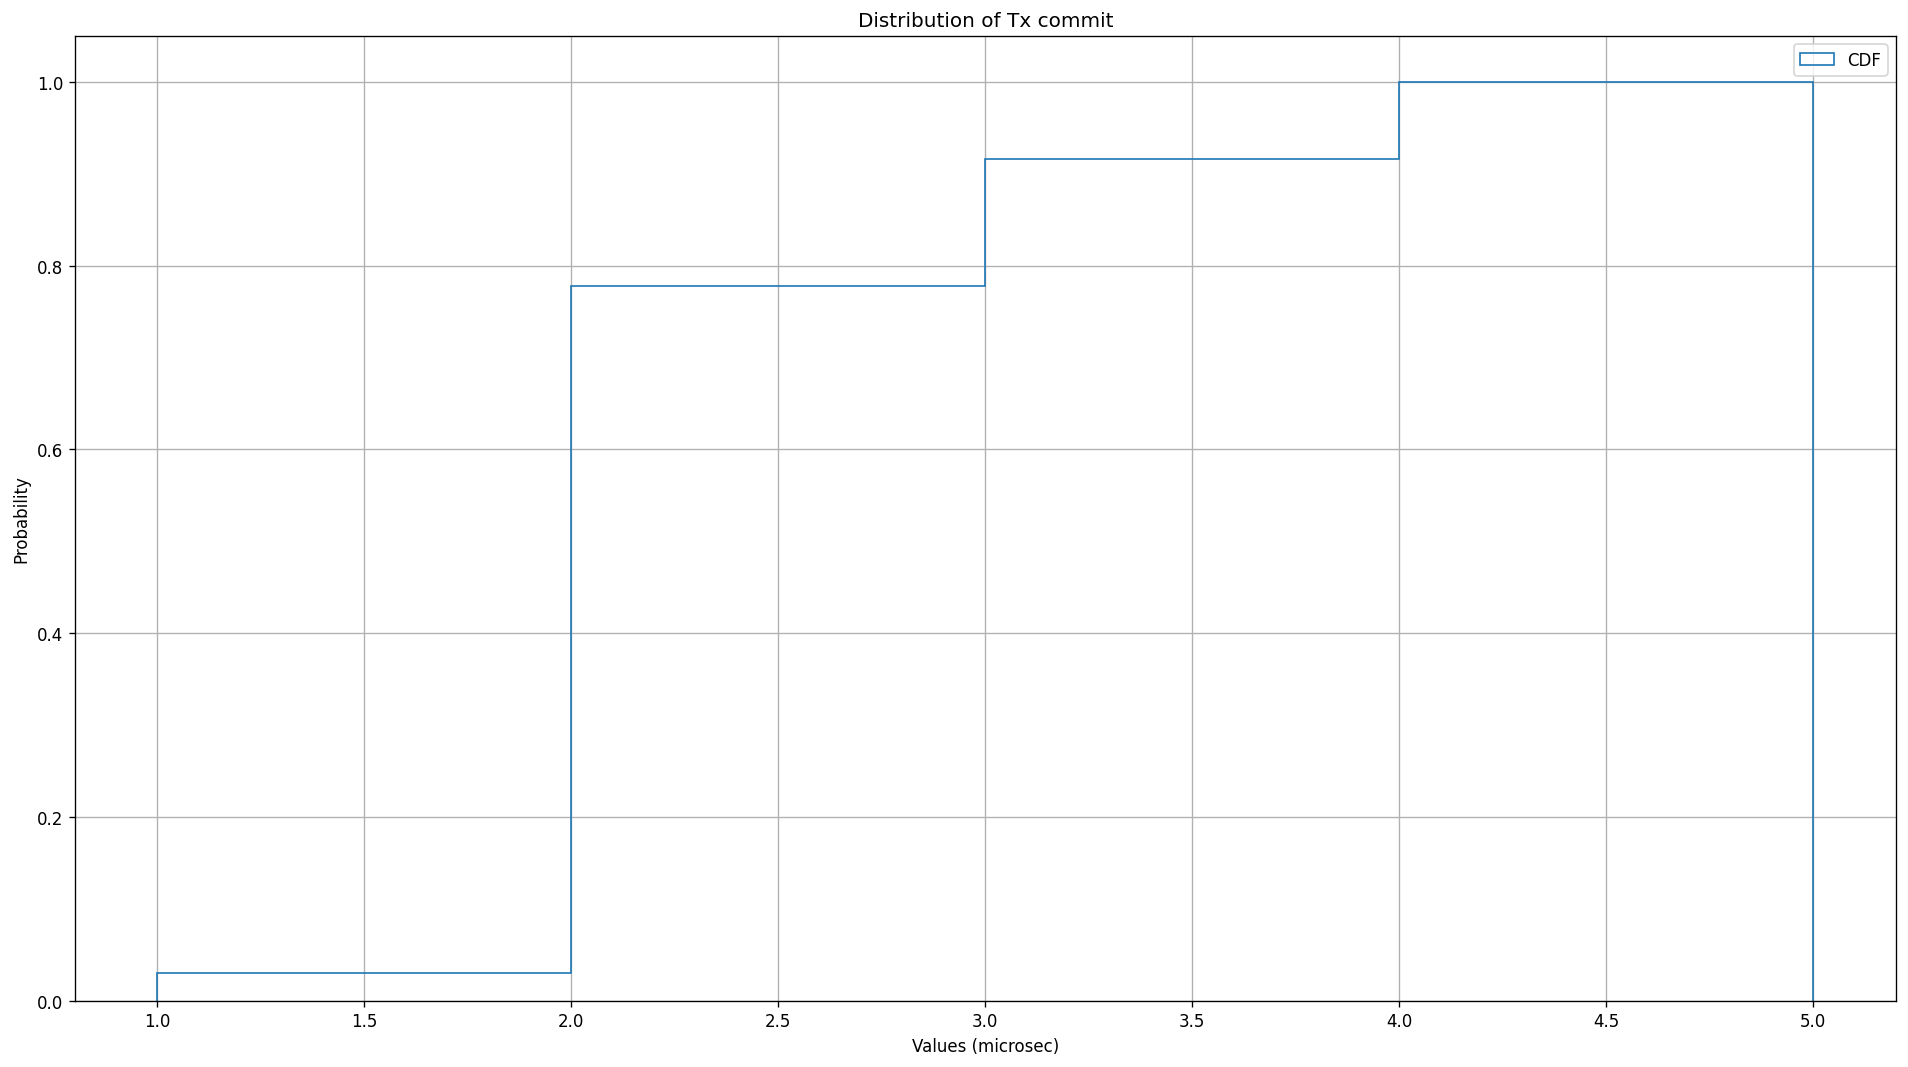

OU8 - TX Commit Features shape: (10000, 13)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes
0,2,0,1,50,0.0,4,0,0,0,0,0,2,0
1,2,0,1,50,0.0,4,0,0,0,0,0,2,0
2,2,0,1,50,0.0,4,0,0,0,0,0,2,0
3,2,0,1,50,0.0,4,0,0,0,0,0,2,0
4,2,0,1,50,0.0,4,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0


OU8 - TX Commit Targets shape: (10000,)


0       4083
1       4652
2       3755
3       4183
4       3655
        ... 
9995    2188
9996    2381
9997    2440
9998    2250
9999    2369
Name: Tx commit, Length: 10000, dtype: int64

In [36]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes'
                ]
targetName = 'Tx commit'

commitFeatures, commitTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSC=False)
print(f'OU8 - TX Commit Features shape: {commitFeatures.shape}')
display(commitFeatures)
print(f'OU8 - TX Commit Targets shape: {commitTargets.shape}')
display(commitTargets)

X_train, X_test, y_train, y_test = train_test_split(commitFeatures, commitTargets, test_size=0.2, random_state=42)

In [6]:
krr = {
        'name': 'KRR',
        'model': KernelRidge(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'alpha': [1.0]
        }
    }
svr = {
        'name': 'SVR',
        'model': SVR(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'C': [0, 0.5, 1.0, 2.0, 4.0]
        }
    }
hr = {
        'name': 'HR',
        'model': HuberRegressor(),
        'param': {
            'epsilon': [1.1, 1.35, 2, 5],
            'alpha': [0, 0.0001, 0.01, 0.1, 1]
        }
    }
rfr = {
        'name': 'RFR',
        'model': RandomForestRegressor(),
        'param': {
            'n_estimators': [50, 100, 500],
            'criterion': ['mse', 'mae'],
            'max_depth': [3, 5, 7, 10],
            'random_state': [0],
            'n_jobs': [None]
        }
    }
modelList = [krr, svr, hr, rfr]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Score on test dataset: -0.17397351310517703


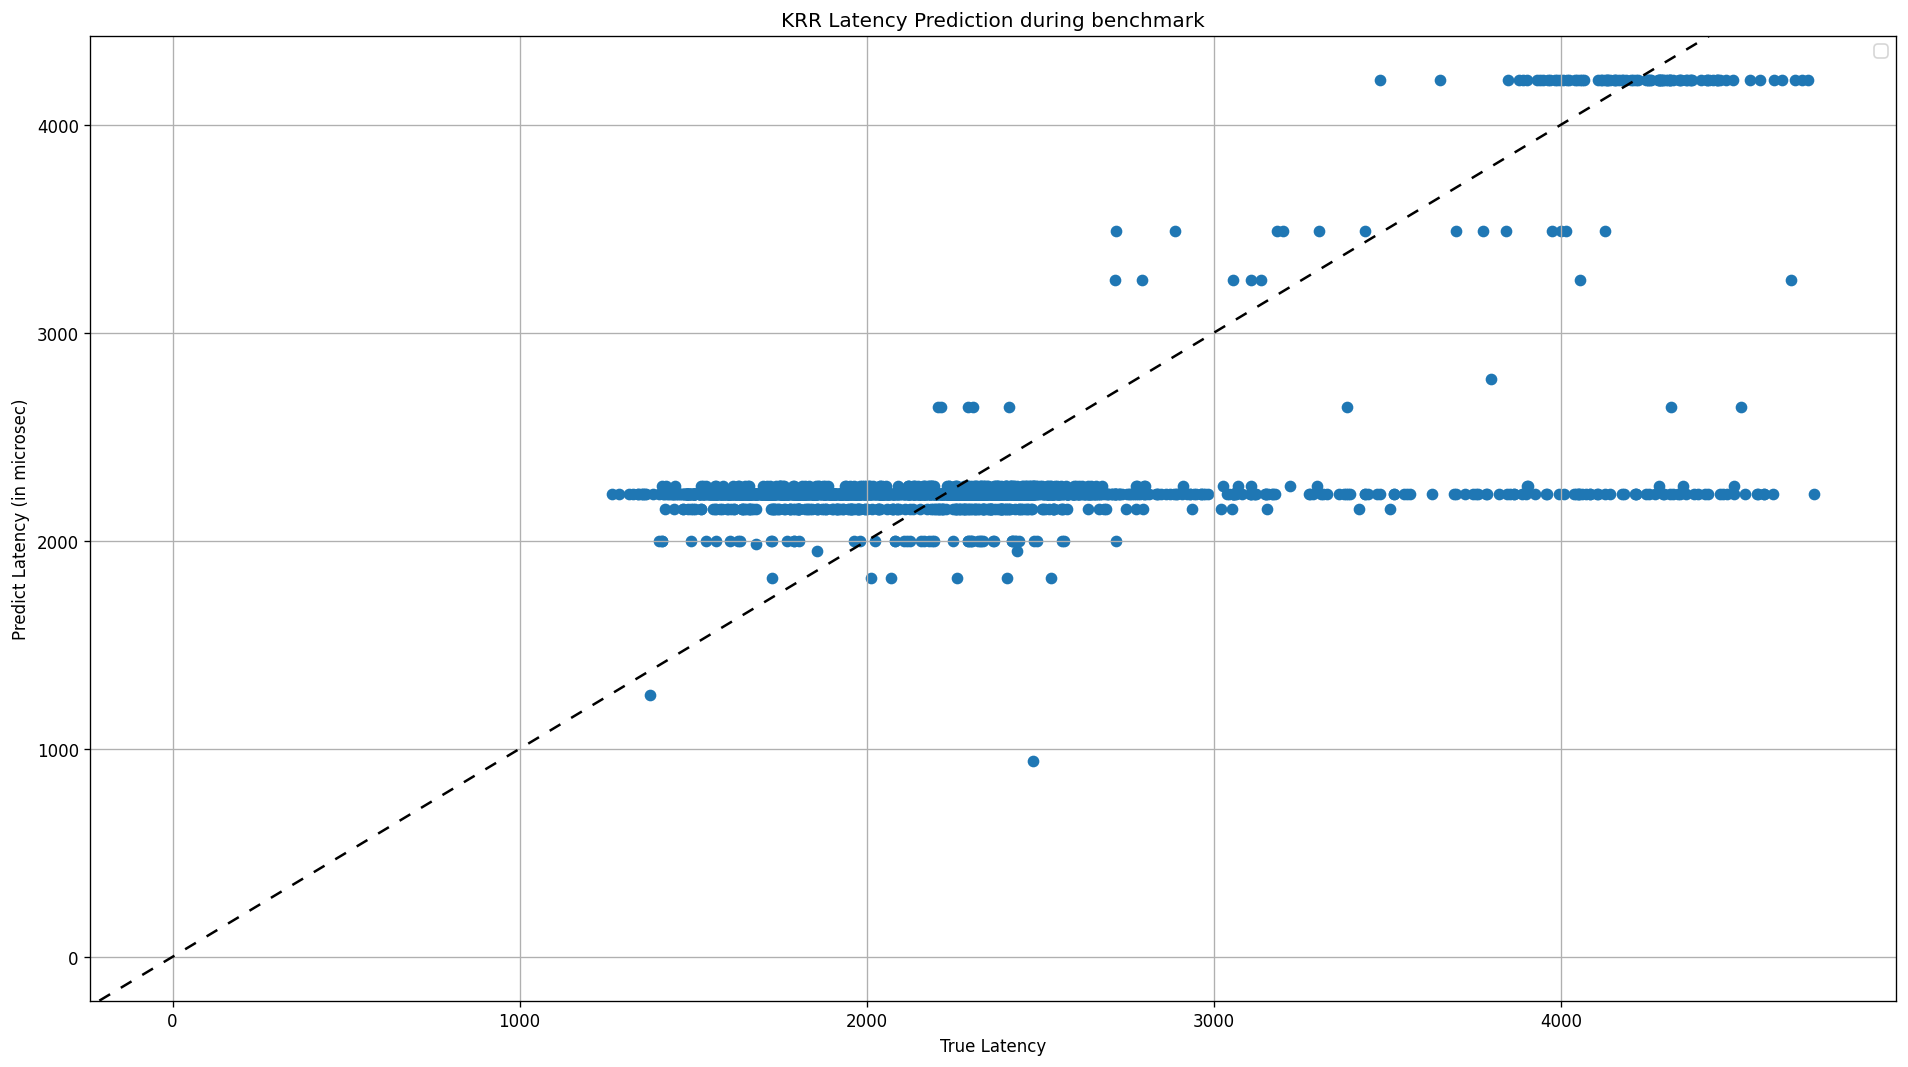

Best Params: {'alpha': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}, with best scores: -0.16883493315743464
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.19097488 -0.19024917
 -0.18983529 -0.18959066 -0.19033292 -0.18872733 -0.18793424 -0.1875617
 -0.18927141 -0.18589236 -0.18436569 -0.1836234  -0.18736003 -0.18100557
 -0.17788467 -0.17646904]
  category=UserWarning
No handles with labels found to put in legend.


Score on test dataset: -0.1799417698283976


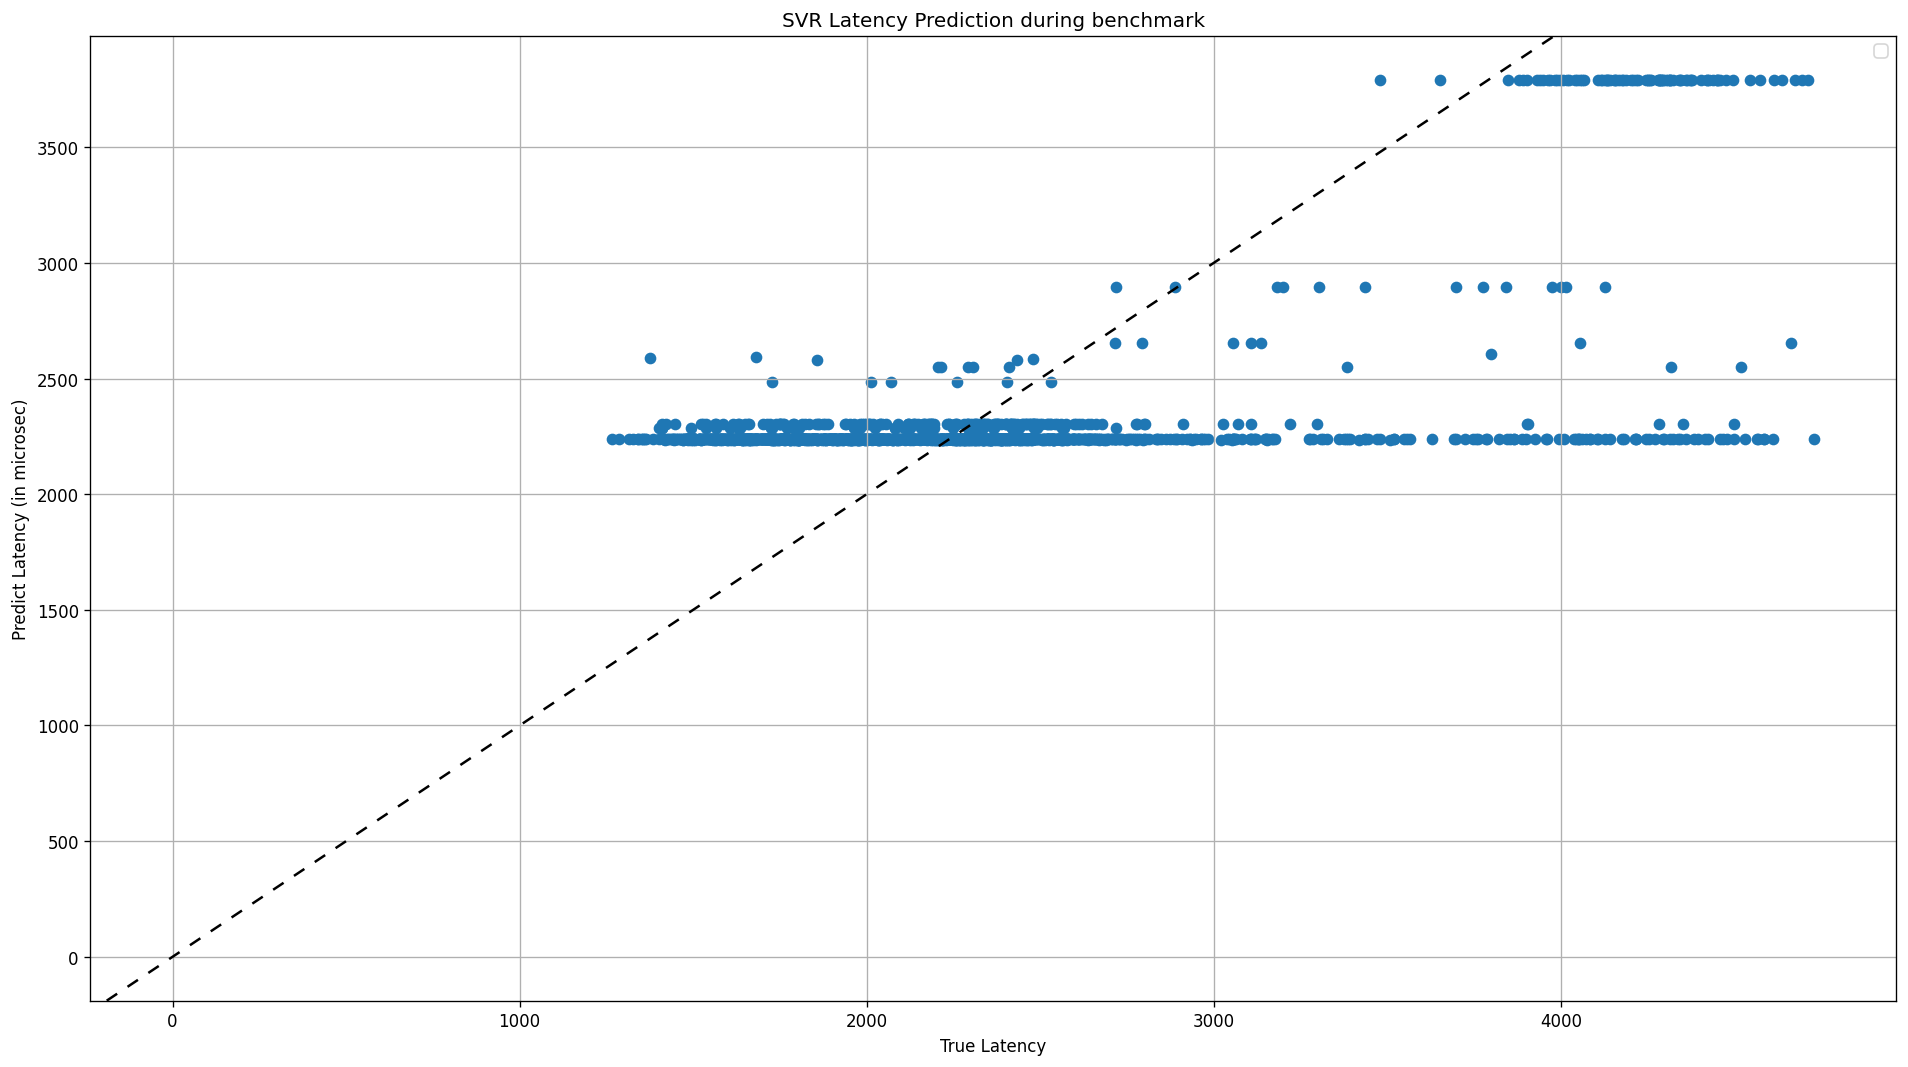

Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}, with best scores: -0.17646904134590446
Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Score on test dataset: -0.19274151416426757


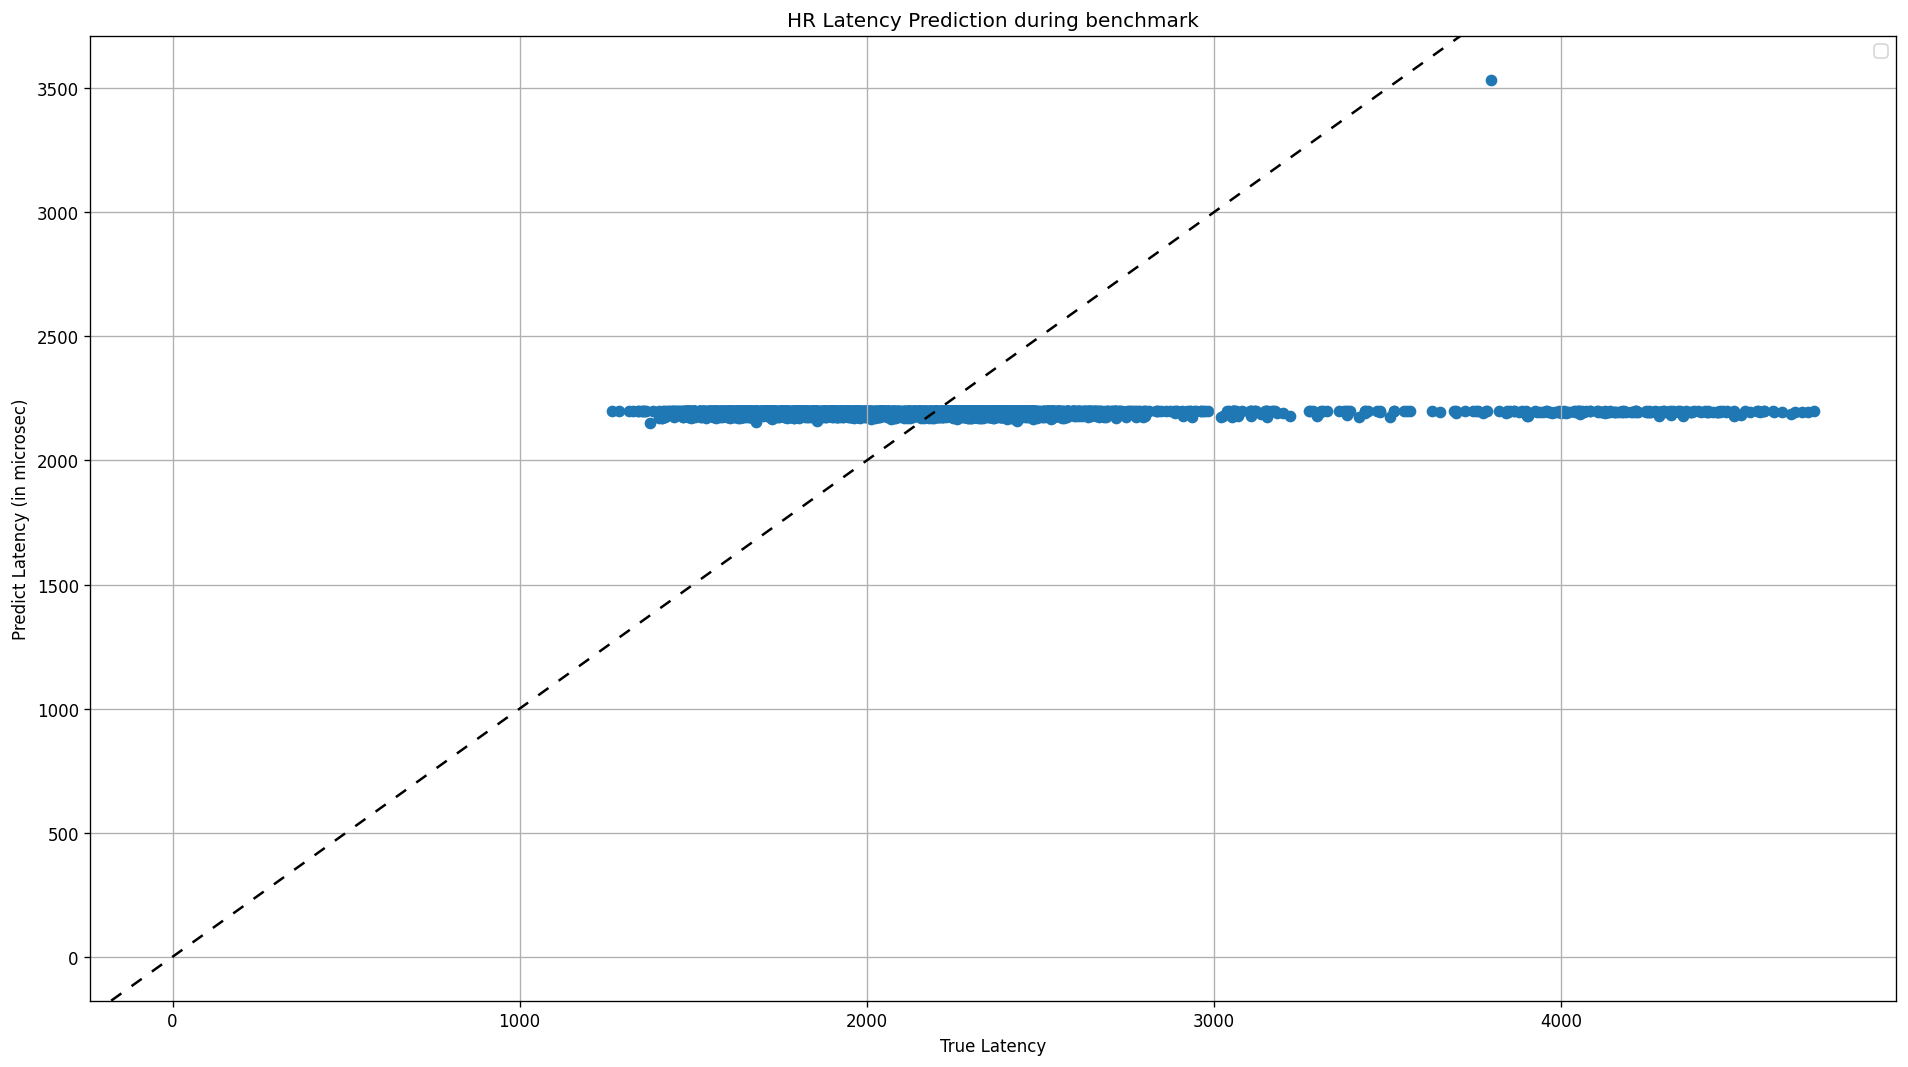

Best Params: {'alpha': 0.01, 'epsilon': 1.35}, with best scores: -0.18822479936716383
Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Score on test dataset: -0.17410162957078604


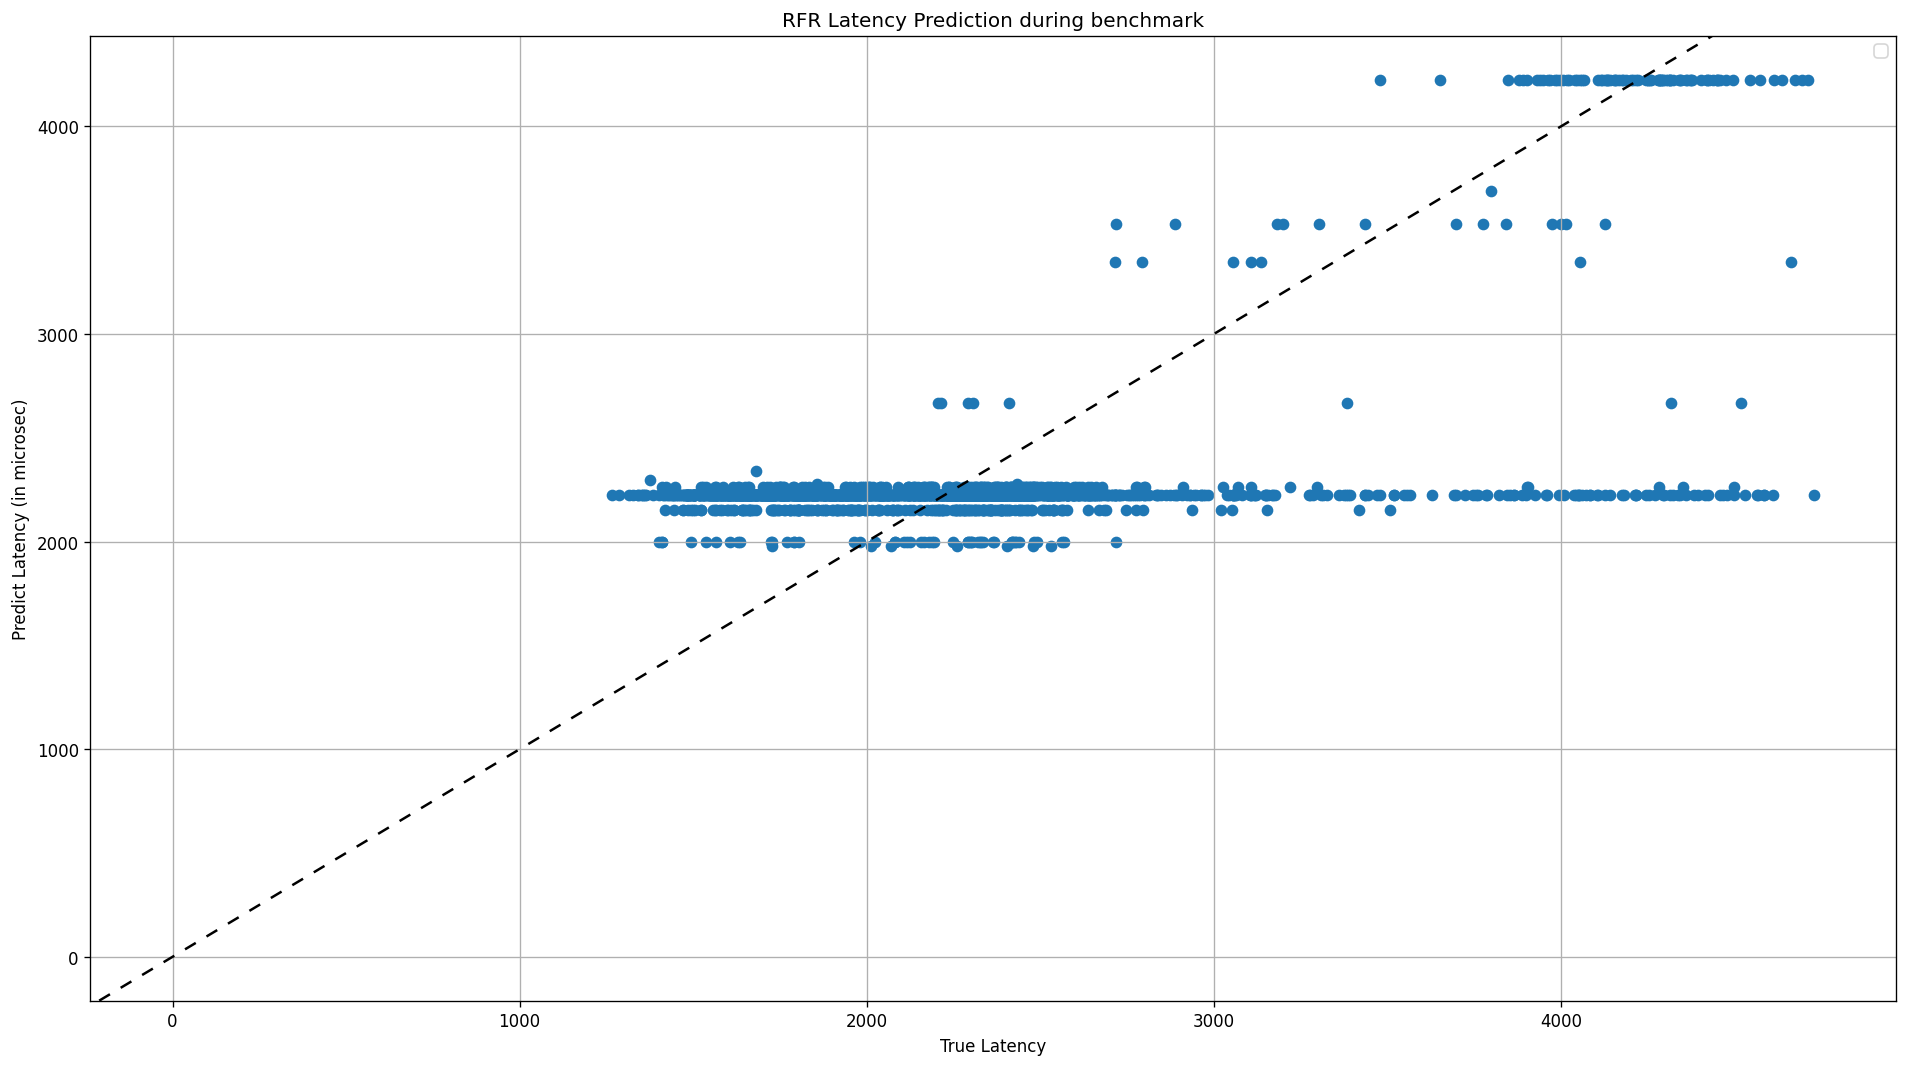

Best Params: {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 50, 'n_jobs': None, 'random_state': 0}, with best scores: -0.16856208092973274


[None, None, None, None]

In [7]:
# for m in modelList:
#     modelSearch(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], n_jobs=-1)
    # fitModel(model, X_train, X_test, y_train, y_test, name=name)

Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], n_jobs=-1) for m in modelList)

# Write Back To Storage

Warm Up Drop Timestamp: 200979929
Mean Latency: 643.7520847419428, Std Latency: 5445.089949096556
In micro sec, Number of bins: 7, nBins: [0. 1. 2. 3. 4. 5. 6.]


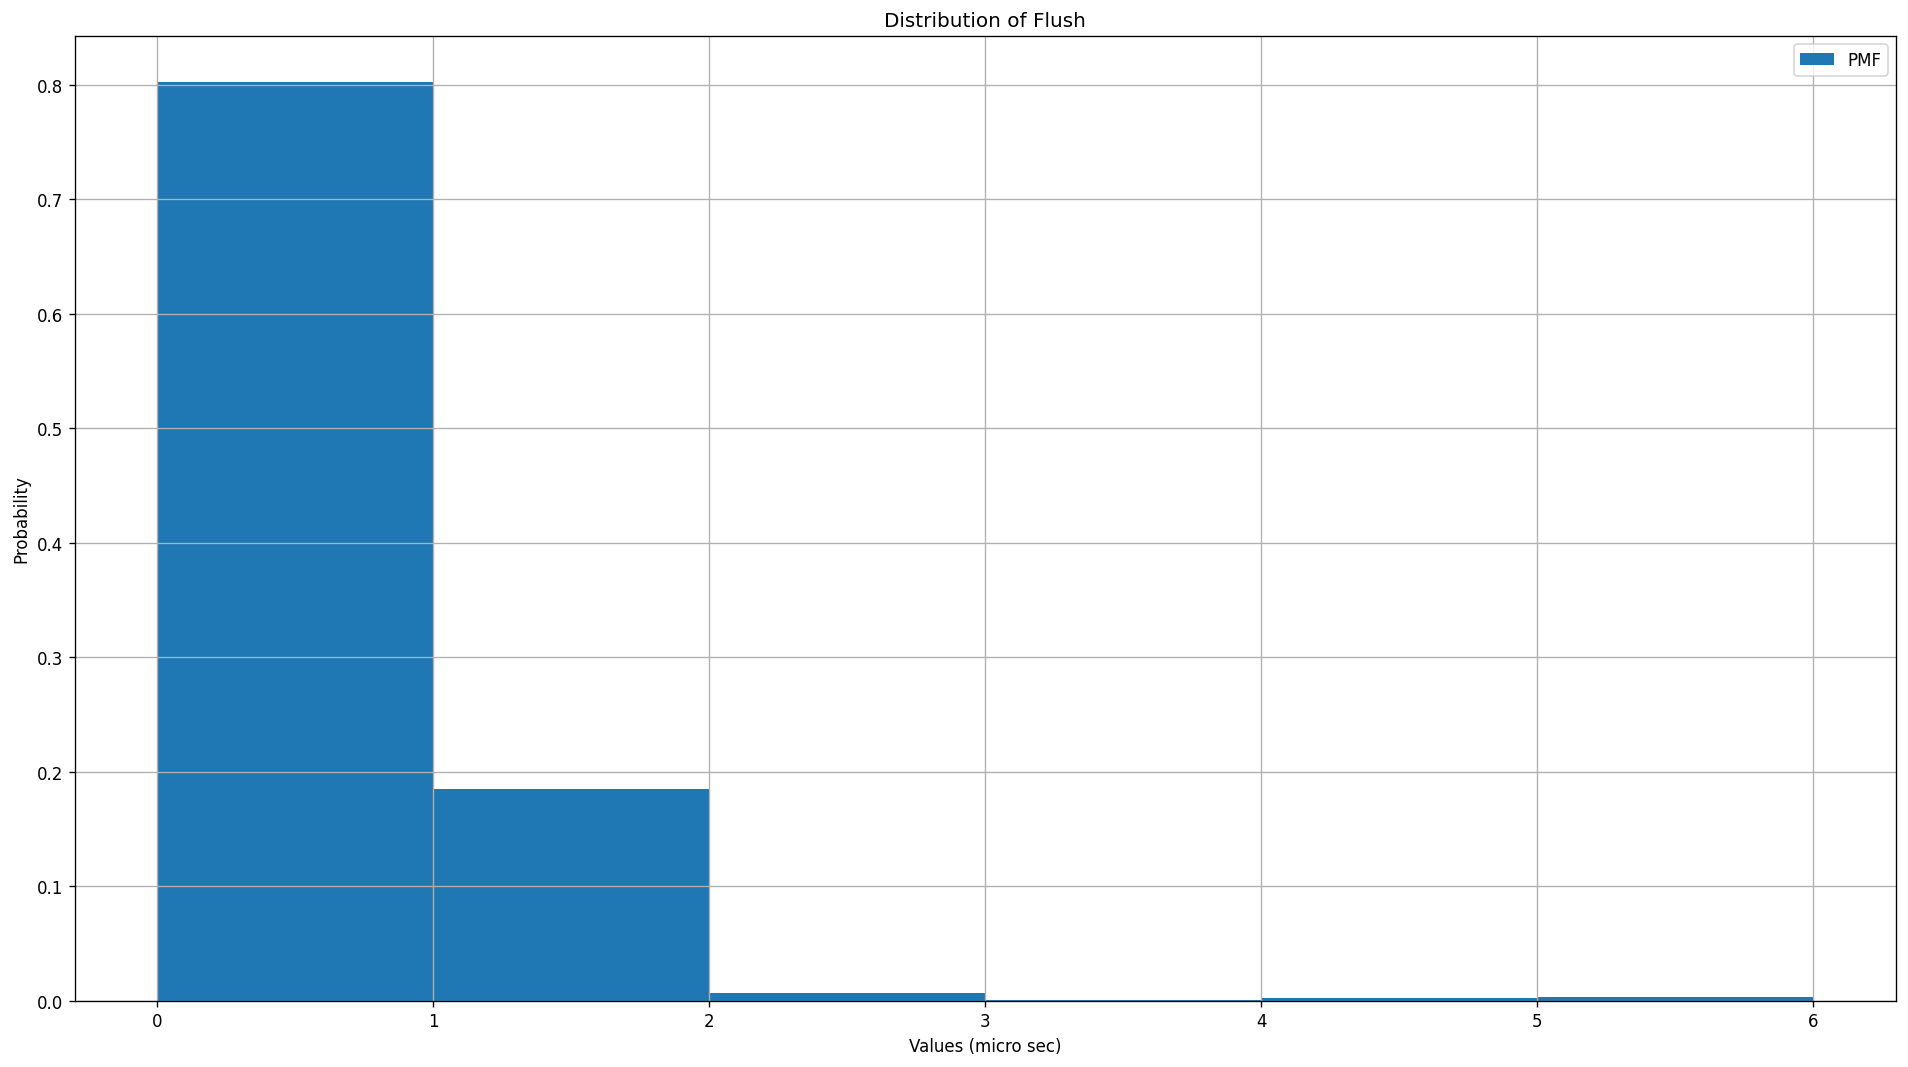

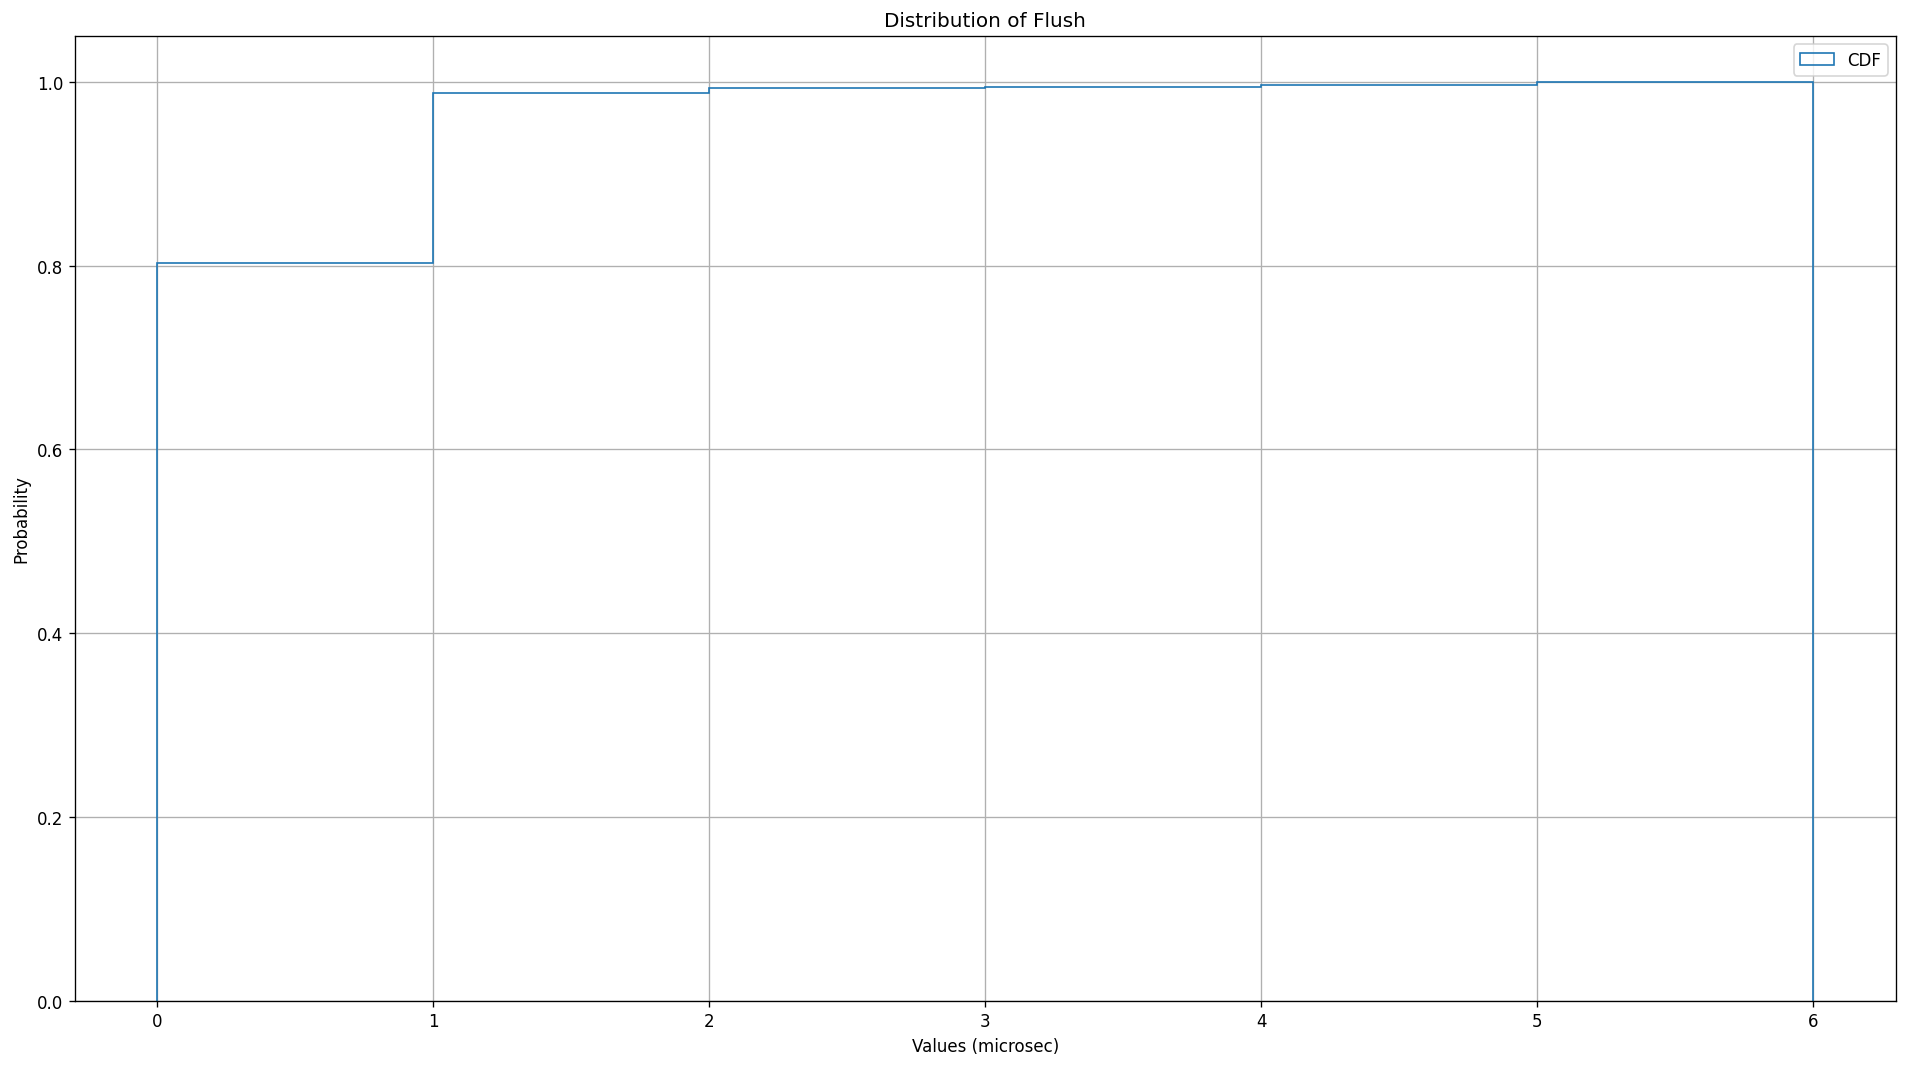

OU7 - Write Local Storage Features shape: (10000, 13)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes
0,2,0,1,50,2.0,4,0,0,0,0,0,2,0
1,2,0,1,50,4.0,4,0,0,0,0,0,2,0
2,2,0,1,50,2.0,4,0,0,0,0,0,2,0
3,2,0,1,50,1.0,4,0,0,0,0,0,2,0
4,2,0,1,50,3.0,4,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9996,2,0,1,50,1.0,4,0,0,0,0,0,2,0
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0


OU7 - Write Local Storage Targets shape: (10000,)


0       4780
1       5355
2       3943
3       4546
4       5256
        ... 
9995     437
9996     886
9997     367
9998     338
9999     395
Name: Flush, Length: 10000, dtype: int64

In [37]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes'
                ]
targetName = 'Flush'

wLocalStorageFeatures, wLocalStorageTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, isSC=False)
print(f'OU7 - Write Local Storage Features shape: {wLocalStorageFeatures.shape}')
display(wLocalStorageFeatures)
print(f'OU7 - Write Local Storage Targets shape: {wLocalStorageTargets.shape}')
display(wLocalStorageTargets)

X_train, X_test, y_train, y_test = train_test_split(wLocalStorageFeatures, wLocalStorageTargets, test_size=0.2, random_state=42)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Score on test dataset: -0.24915704075523762


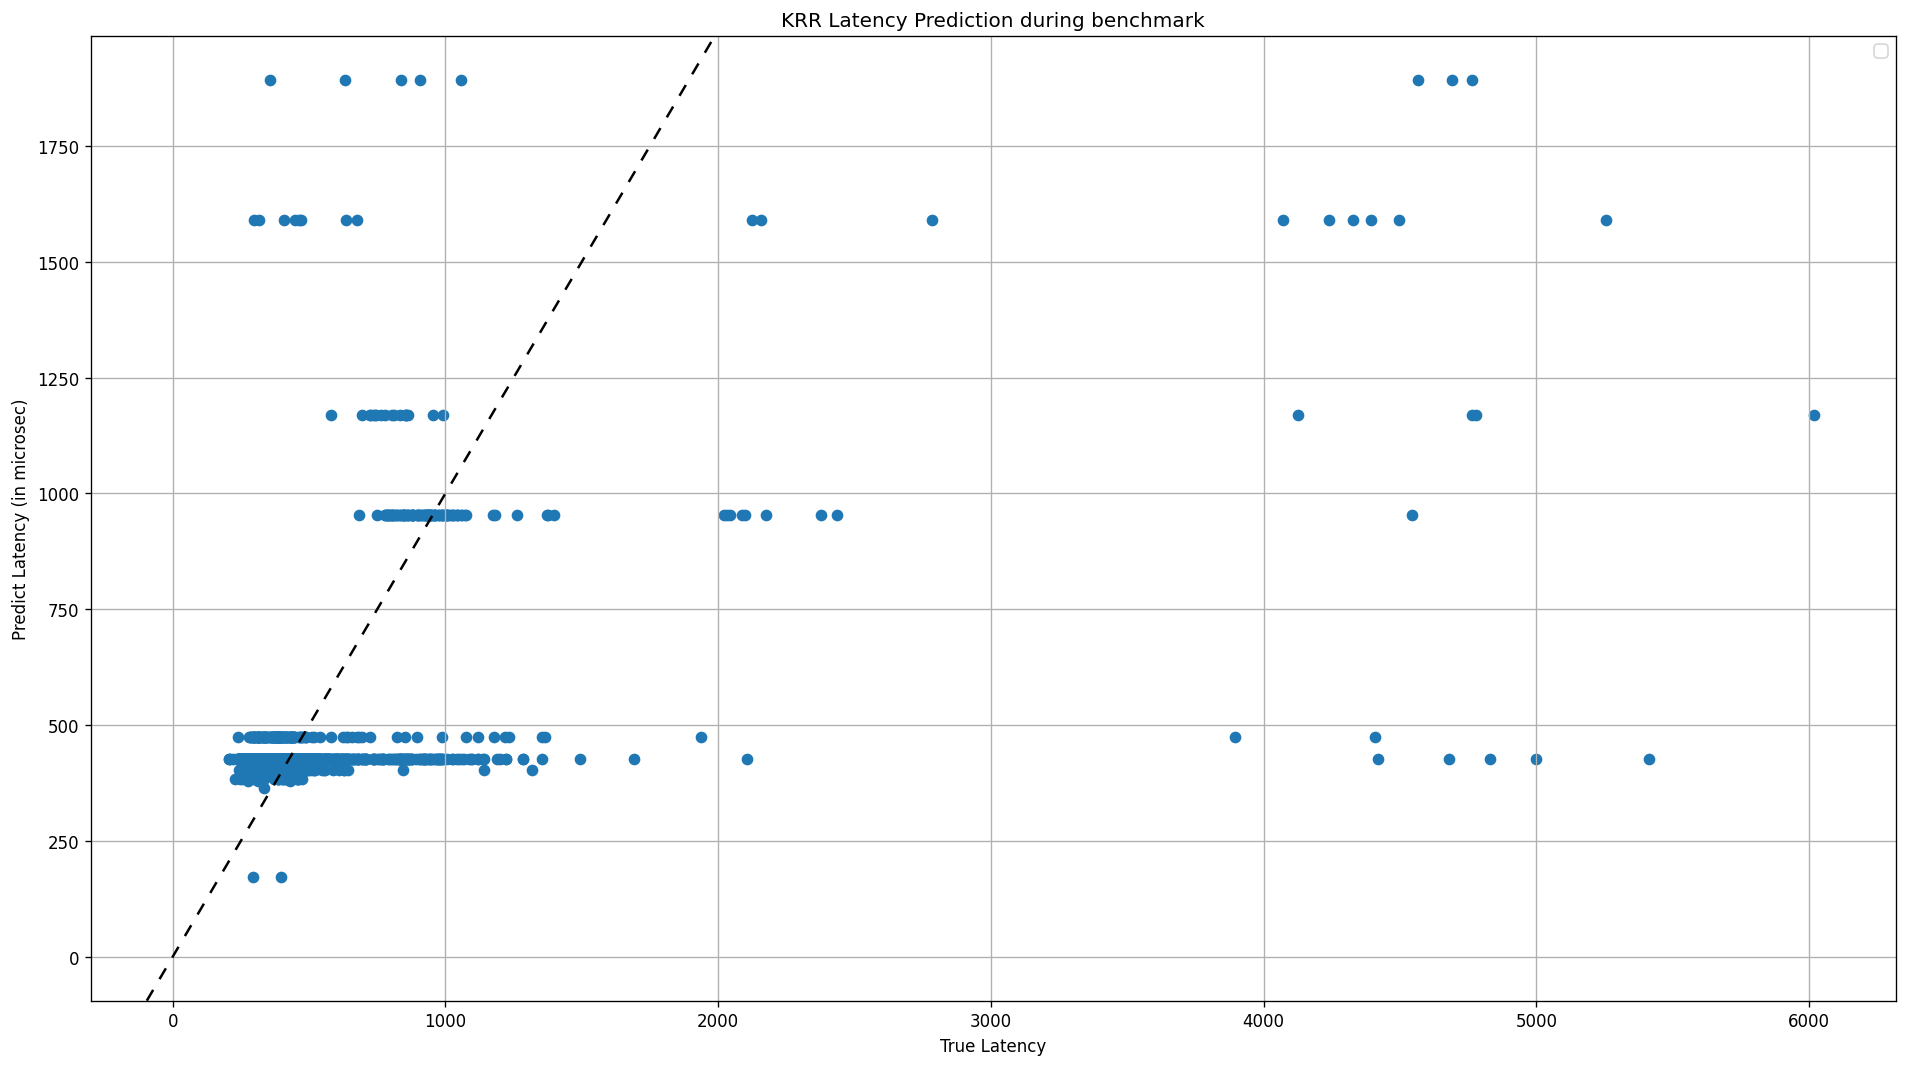

Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}, with best scores: -0.24206100932035374
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.21251265 -0.20778745
 -0.20568764 -0.20447895 -0.21035544 -0.20095721 -0.19679437 -0.19542461
 -0.20691761 -0.19219861 -0.19058237 -0.19043871 -0.20134961 -0.18876457
 -0.18815843 -0.18850449]
  category=UserWarning
No handles with labels found to put in legend.


Score on test dataset: -0.19813923484969825


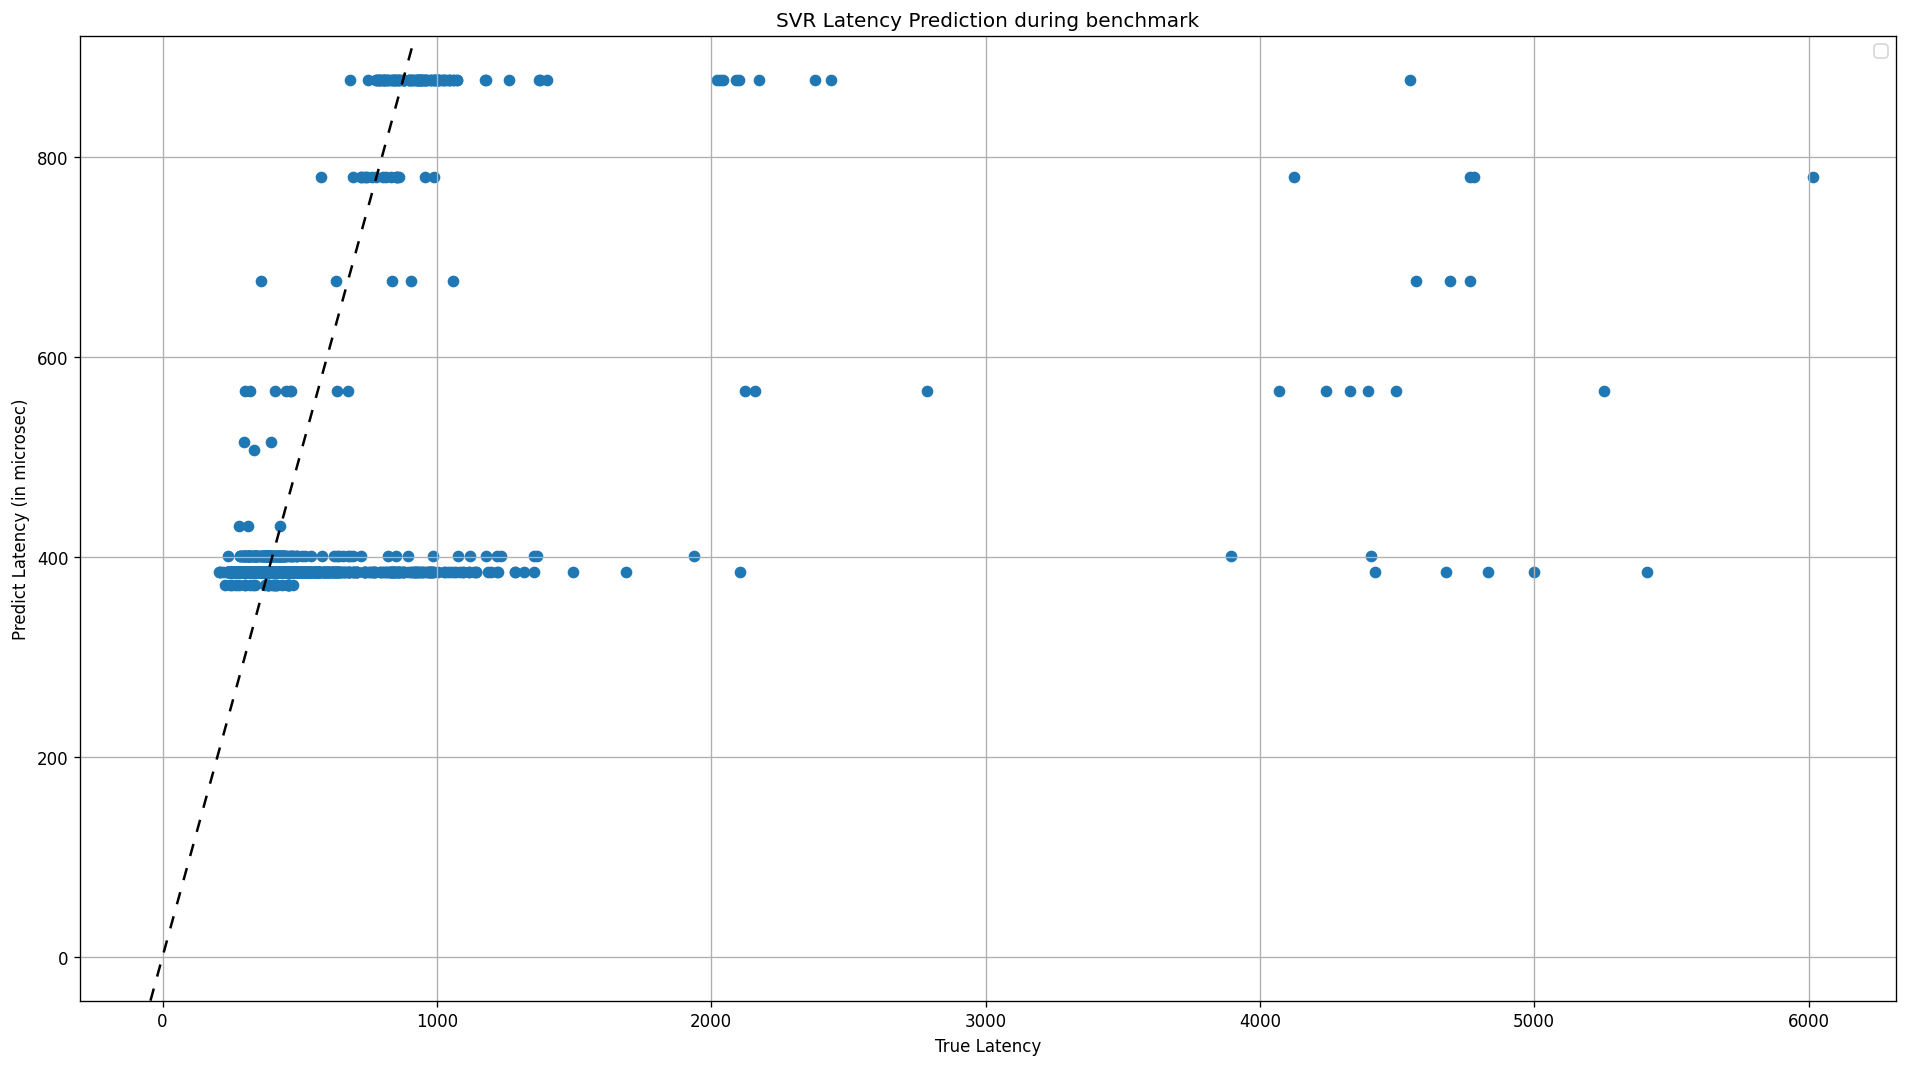

Best Params: {'C': 4.0, 'gamma': 1.0, 'kernel': 'rbf'}, with best scores: -0.18815843386813677
Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Score on test dataset: -0.22737937686559656


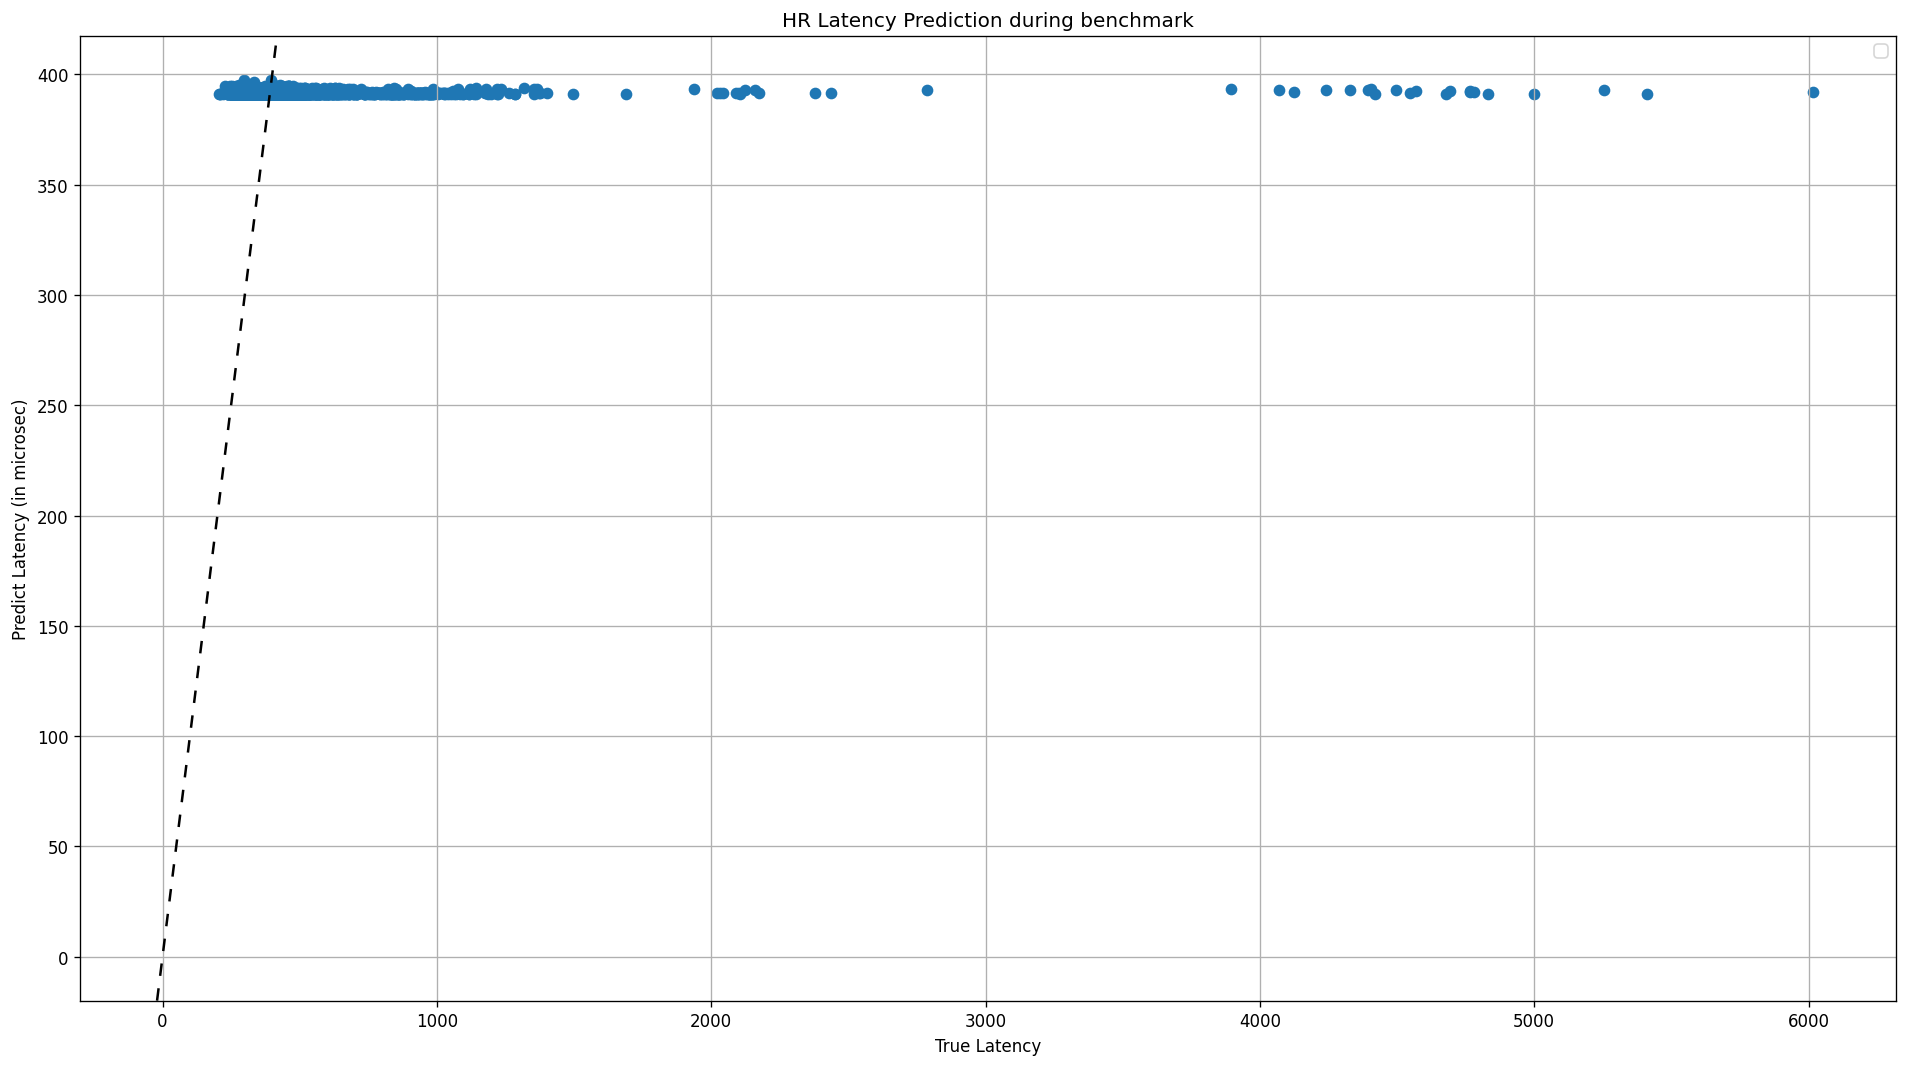

Best Params: {'alpha': 1, 'epsilon': 1.1}, with best scores: -0.2159209817946599
Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Score on test dataset: -0.19948910177828078


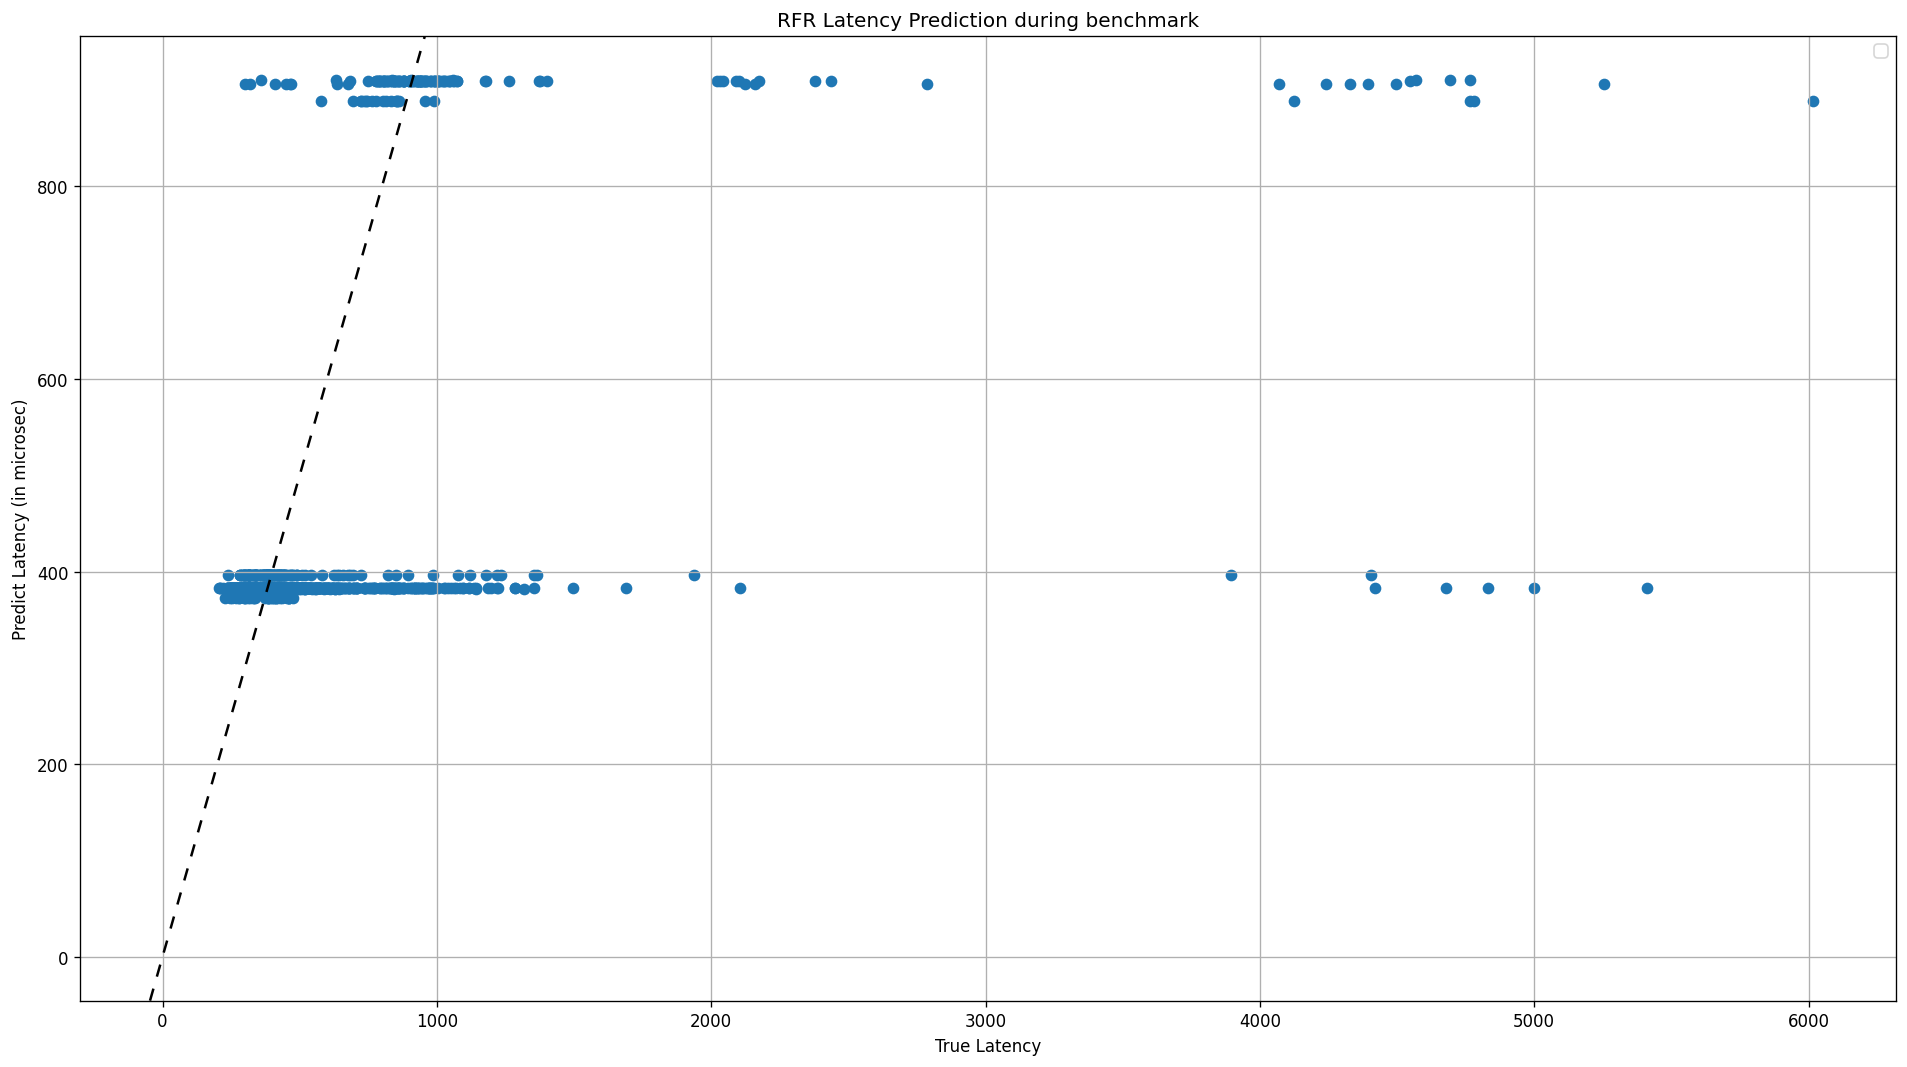

Best Params: {'criterion': 'mae', 'max_depth': 3, 'n_estimators': 500, 'n_jobs': None, 'random_state': 0}, with best scores: -0.18891049115364372


[None, None, None, None]

In [9]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], n_jobs=-1) for m in modelList)

# Execute Txn Logic

Warm Up Drop Timestamp: 200979929
Mean Latency: 643.3262273131024, Std Latency: 806.4236911676418
In micro sec, Number of bins: 2, nBins: [0. 1.]


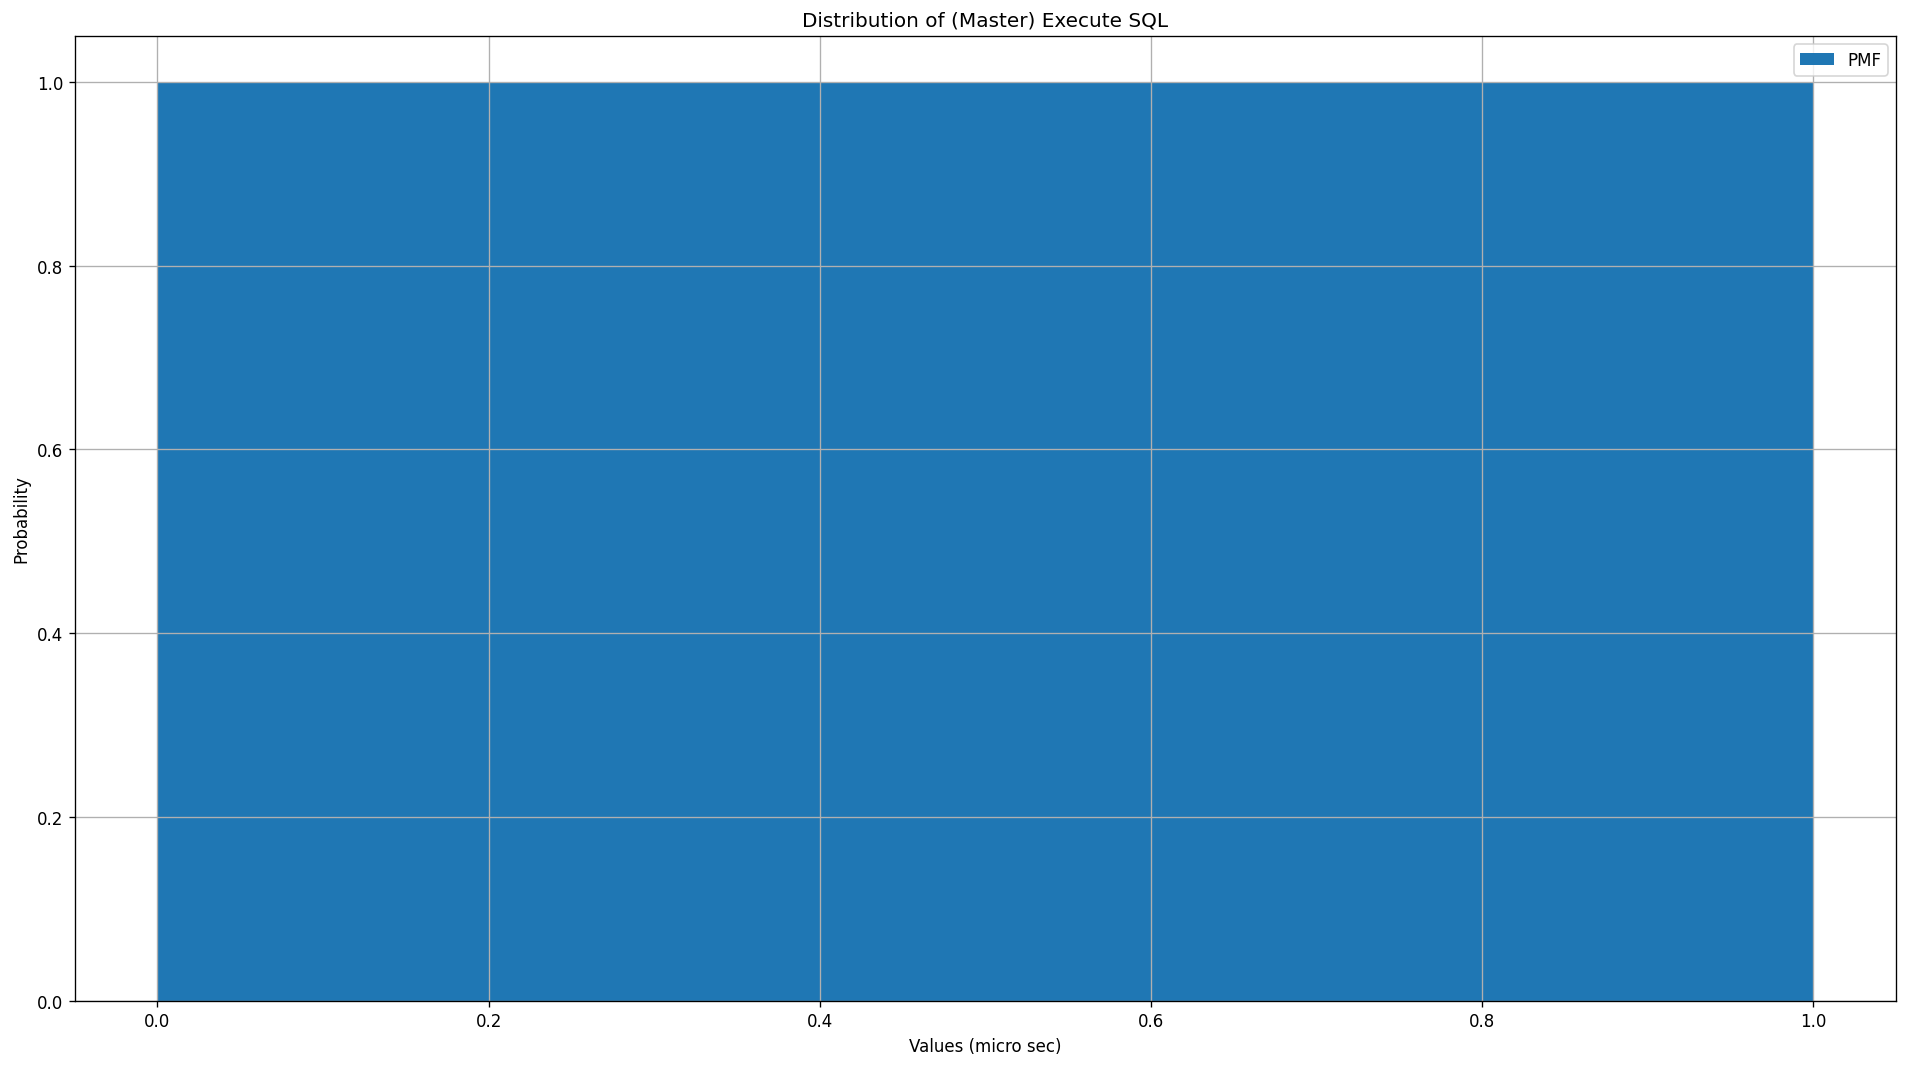

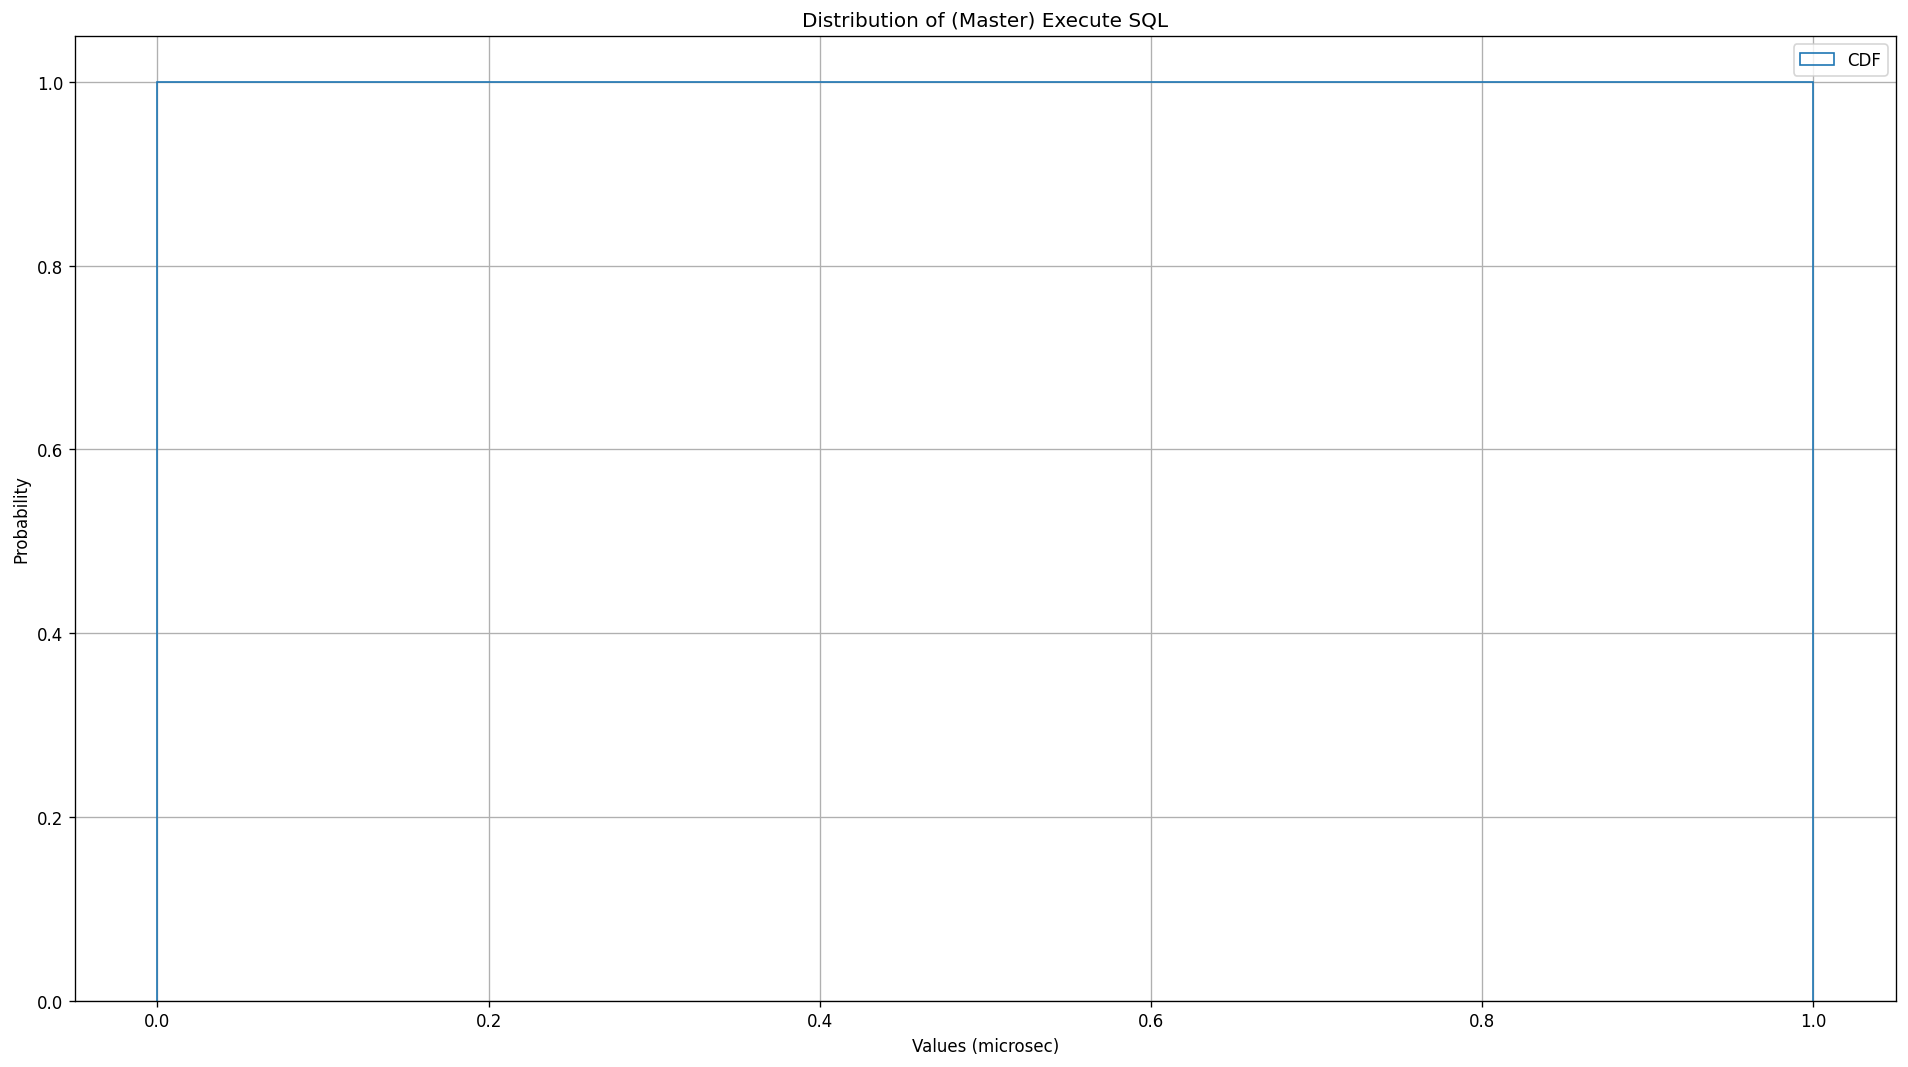

OU8 - TX Commit Features shape: (10000, 13)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes
0,2,0,1,50,0.0,4,0,0,0,0,0,2,0
1,2,0,1,50,0.0,4,0,0,0,0,0,2,0
2,2,0,1,50,0.0,4,0,0,0,0,0,2,0
3,2,0,1,50,0.0,4,0,0,0,0,0,2,0
4,2,0,1,50,0.0,4,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0


OU8 - TX Commit Targets shape: (10000,)


0       1245
1       1173
2        923
3       1376
4       1386
        ... 
9995     553
9996     574
9997     567
9998     506
9999     520
Name: (Master) Execute SQL, Length: 10000, dtype: int64

In [38]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes'
                ]
targetName = '(Master) Execute SQL'

commitFeatures, commitTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, isSC=False)
print(f'OU8 - TX Commit Features shape: {commitFeatures.shape}')
display(commitFeatures)
print(f'OU8 - TX Commit Targets shape: {commitTargets.shape}')
display(commitTargets)

X_train, X_test, y_train, y_test = train_test_split(commitFeatures, commitTargets, test_size=0.2, random_state=42)

# Generating Execution Plan

Warm Up Drop Timestamp: 200979929
Mean Latency: 29085.39045327394, Std Latency: 699022.4085093733
In micro sec, Number of bins: 114, nBins: [  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98. 100. 101. 102. 105.
 106. 107. 109. 112. 113. 114. 116. 118. 119. 124. 130. 139. 148. 182.
 275. 304.]


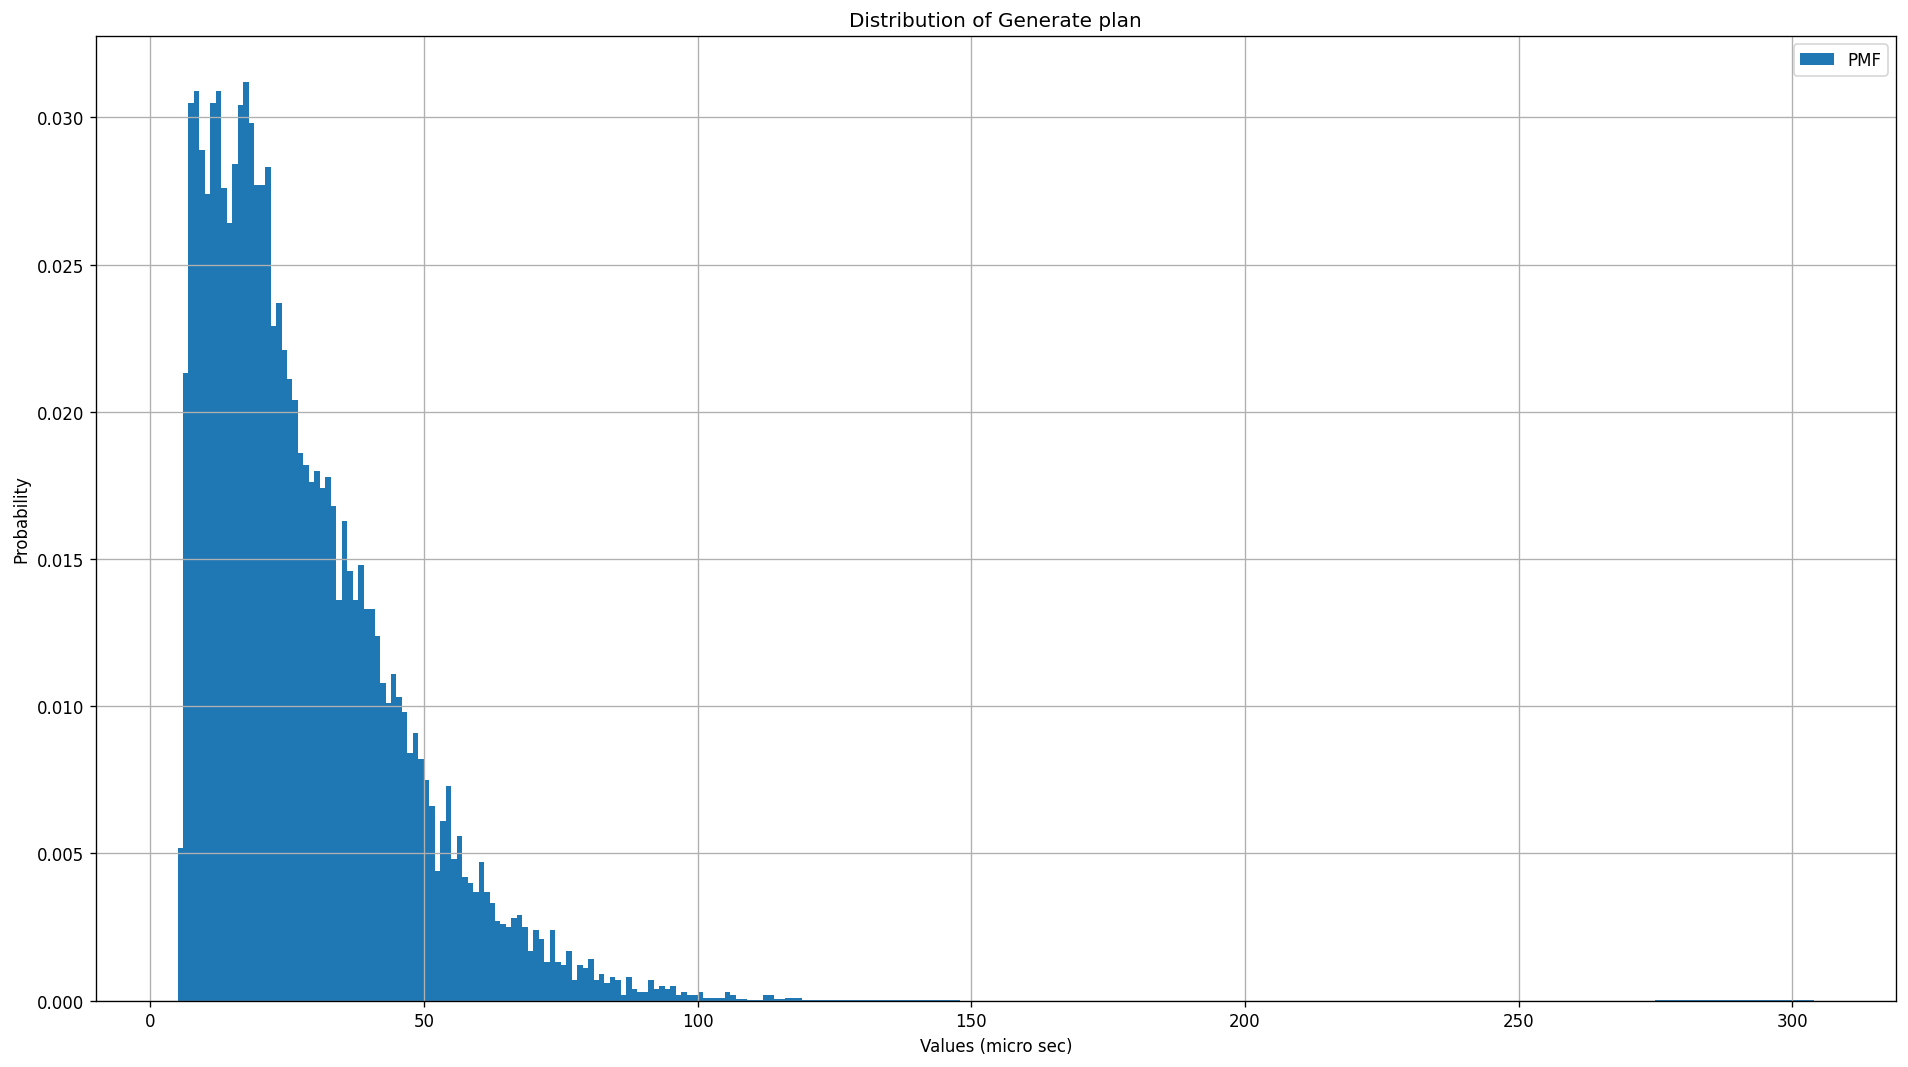

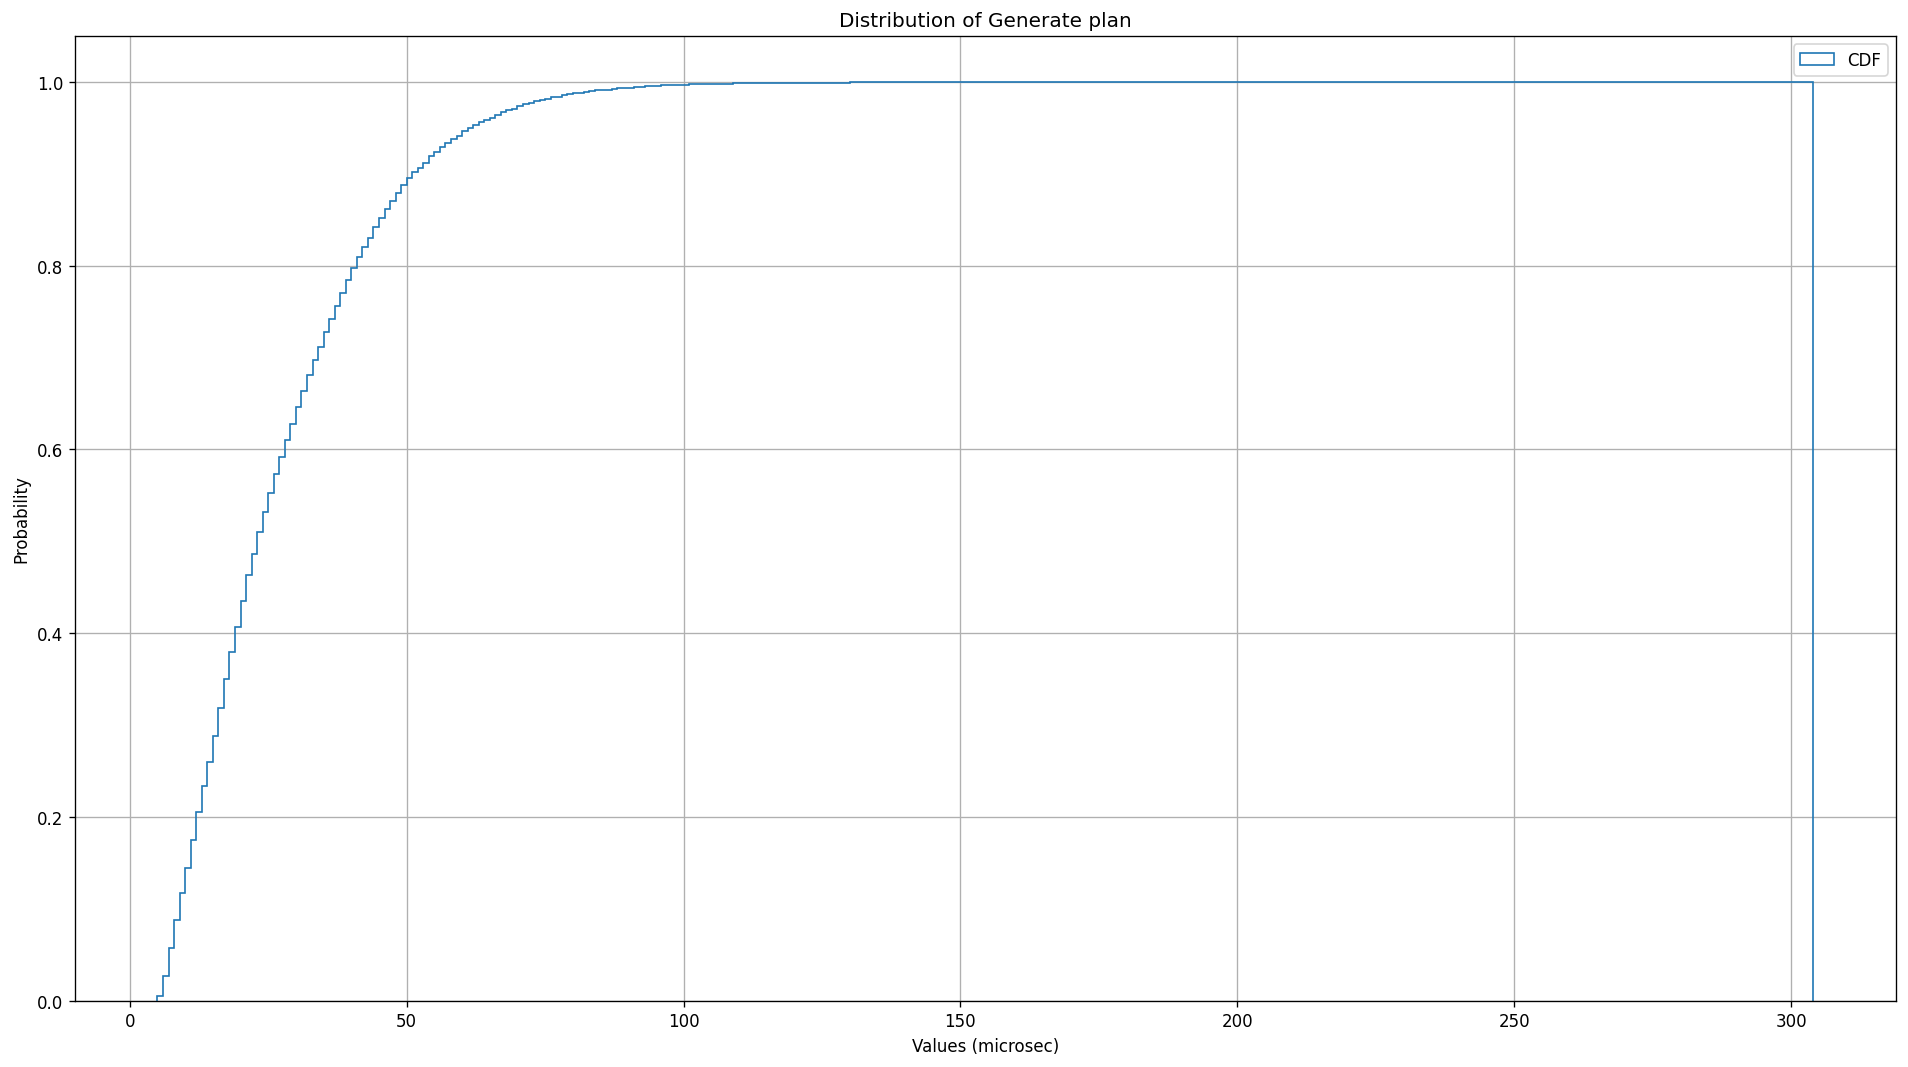

OU1 - Generating Plan Features shape: (10000, 13)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes
0,2,0,1,50,2.0,4,0,0,0,0,0,2,0
1,2,0,1,50,4.0,4,0,0,0,0,0,2,0
2,2,0,1,50,5.0,4,0,0,0,0,0,2,0
3,2,0,1,50,3.0,4,0,0,0,0,0,2,0
4,2,0,1,50,1.0,4,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0
9997,2,0,1,50,1.0,4,0,0,0,0,0,2,0
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0


OU1 - Generating Plan Targets shape: (10000,)


0        69675
1        78525
2       105439
3       129990
4       101301
         ...  
9995     54884
9996     38937
9997     20130
9998     16019
9999     26109
Name: Generate plan, Length: 10000, dtype: int64

In [39]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes'
                ]
targetName = 'Generate plan'

commitFeatures, commitTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, warmupDrop=warmupDrop, outlinerDrop=outlinerDropR,  sample=sampleN, isSC=False)
print(f'OU1 - Generating Plan Features shape: {commitFeatures.shape}')
display(commitFeatures)
print(f'OU1 - Generating Plan Targets shape: {commitTargets.shape}')
display(commitTargets)

X_train, X_test, y_train, y_test = train_test_split(commitFeatures, commitTargets, test_size=0.2, random_state=42)